In [339]:
import pandas as pd

import numpy as np
from numpy import dot
from numpy.linalg import norm

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from unidecode import unidecode

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, silhouette_score
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

# from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC

In [340]:
def standardize_names(name):
    name = name.replace('-', ' ')
    name = name.replace("'", '')
    name = name.title()    
    return name

def standardize_positions(input_list, position_dict):
    # Remove extra positions
    positions_list = [position.split(',')[0] for position in input_list]
    
    # Standardize
    standardized = [position_dict[position] if position in position_dict else position for position in positions_list]
    
    return standardized

def player_values(player_df):
    output = player_df.drop(['player'], axis=1)
    output = output.values.tolist()[0]
    return output
    
def cosine_similarity(list_1, list_2):
    cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
    return cos_sim

def euclidean_distance(list_1, list_2):
    distance = np.linalg.norm(list_1 - list_2)
    return distance

def cosine_similar_players(target_player, df):
    target_player_row = df[df['player'] == target_player].drop(['player'], axis=1)
    target_player_list = target_player_row.values.tolist()[0]
    
    cosine_list = []
    for player in df['player']:
        player_row = df[df['player'] == player].drop(['player'], axis=1)
        player_vals = player_row.values.tolist()
        
        if len(player_vals) == 1:
            player_list = player_vals[0]
            cosine = cosine_similarity(target_player_list, player_list)
            cosine_list.append(cosine)
            
        else:
            cosine_list.append(0)
            
    output_df = pd.DataFrame()
    output_df['player'] = df['player']
    output_df['value'] = cosine_list

    output_df = output_df.sort_values('value', ascending=False).reset_index(drop=True).head(11)

    return output_df
            
def euclidean_similar_players(target_player, df):
    target_player_row = df[df['player'] == target_player].drop(['player'], axis=1)
    target_player_list = target_player_row.values.tolist()[0]
    target_player_list = np.array(target_player_list)
    
    euclidean_list = []
    for player in df['player']:
        player_row = df[df['player'] == player].drop(['player'], axis=1)
        player_vals = player_row.values.tolist()
        
        if len(player_vals) == 1:
            player_list = player_vals[0]
            player_list = np.array(player_list)
            euclidean = euclidean_distance(target_player_list, player_list)
            euclidean_list.append(euclidean)
            
        else:
            euclidean_list.append(0)

    output_df = pd.DataFrame()
    output_df['player'] = df['player']
    output_df['value'] = euclidean_list
    output_df['value'] = output_df['value'].round(4)

    output_df = output_df.sort_values('value', ascending=True).reset_index(drop=True).head(12)

    return output_df

# def radar_plot(features):
#     categories = features

#     fig = go.Figure()

#     fig.add_trace(go.Scatterpolar(
#           r=[1, 5, 2, 2, 3],
#           theta=categories,
#           fill='toself',
#           name='Product A'
#     ))
#     fig.add_trace(go.Scatterpolar(
#           r=[4, 3, 2.5, 1, 2],
#           theta=categories,
#           fill='toself',
#           name='Product B'
#     ))

#     fig.update_layout(
#       polar=dict(
#         radialaxis=dict(
#           visible=True,
#           range=[0, 5]
#         )),
#       showlegend=False
#     )

#     fig.show()

# Perliminary Analysis

### Read Data / Clean Data

In [341]:
# Read in CSV with players on pitch data
s21_22 = pd.read_csv('all_leagues_21_22.csv')
# with small sample sizes
s21_22 = s21_22.drop_duplicates(subset=['Player'])
s21_22 = s21_22[s21_22['Minutes 90S'] > 10]
s21_22 = s21_22[s21_22['Position'] != 'GK']

In [342]:
s21_22

,Player,Nationality,Team,Position,Age,Comp Level,Games,Games Starts,Minutes,Minutes 90S,...,Touches Att 3Rd_Per90,Touches Att Pen Area_Per90,Touches Live Ball_Per90,Dribbles Completed_Per90,Dribbles_Per90,Dribbles Completed Pct_Per90,Miscontrols_Per90,Dispossessed_Per90,Passes Received_Per90,Progressive Passes Received_Per90
2,Aaron Connolly,IRL,Middlesbrough,FW,21.0,Championship,23,14.0,1339,14.8,...,26.11,7.16,42.54,0.69,2.48,4.04,4.54,2.48,30.19,8.42
3,Aaron Cresswell,ENG,West Ham,DF,31.0,Premier League,31,31.0,2726,30.3,...,18.51,0.73,75.31,0.26,0.56,1.55,0.46,0.13,49.34,1.16
4,Aaron Herrera,USA,Real Salt Lake,DF,24.0,MLS,27,25.0,2268,25.2,...,16.79,0.95,66.39,0.91,1.39,2.61,1.15,0.56,40.36,1.51
5,Aaron Hickey,SCO,Bologna,DF,19.0,Serie A,36,34.0,2820,31.3,...,14.31,0.77,50.26,0.96,1.57,1.96,1.53,0.86,30.38,2.14
6,Aaron Lennon,ENG,Burnley,"MF,FW",34.0,Premier League,28,17.0,1551,17.2,...,13.95,2.38,31.45,0.76,1.74,2.52,1.45,0.76,19.24,2.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,Óscar de Marcos,ESP,Athletic Club,DF,32.0,La Liga,22,19.0,1679,18.7,...,18.98,1.07,68.18,0.21,0.70,1.65,0.53,0.37,36.79,1.93
6398,Þorleifur Úlfarsson,ISL,Houston Dynamo,FW,21.0,MLS,31,11.0,1202,13.4,...,12.61,5.30,26.42,0.45,0.75,4.48,1.64,0.45,17.01,5.00
6400,İlkay Gündoğan,GER,Manchester City,MF,30.0,Premier League,27,20.0,1857,20.6,...,29.17,4.13,73.88,1.17,1.70,3.33,1.21,0.92,58.45,5.05
6403,Šime Vrsaljko,CRO,Atlético Madrid,DF,29.0,La Liga,21,10.0,914,10.2,...,18.63,0.98,69.80,0.49,0.69,7.00,1.37,0.69,39.41,1.18


In [344]:
twitter_players = pd.read_csv('players_raw.txt')
twitter_players.columns = ['Player', 'FBref_Url', 'Tmarkt_Url', 'sub_position']
twitter_players = twitter_players[['Player', 'sub_position']]
positional_data = twitter_players
twitter_players

,Player,sub_position
0,A.J. DeLaGarza,Right-Back
1,Aapo Halme,Centre-Back
2,Aaron Bastiaans,Left Winger
3,Aaron Connolly,Centre-Forward
4,Aaron Cresswell,Left-Back
...,...,...
14044,Zoltán Stieber,Attacking Midfield
14045,Zorhan Bassong,Left-Back
14046,Zouhair Feddal,Centre-Back
14047,Zourdine Mouhemed Thior,Right Winger


In [346]:
position_filter = positional_data['sub_position'].isin(['Attacking Midfield',
 'Central Midfield',
 'Centre-Back',
 'Centre-Forward',
 'Defensive Midfield',
 'Goalkeeper',
 'Left Midfield',
 'Left Winger',
 'Left-Back',
 'Right Midfield',
 'Right Winger',
 'Right-Back',
 'Second Striker'])

positional_data = positional_data[position_filter]

In [348]:
# Convert positions with left/right sides to a standardized version
position_standards = {
    'Left-Back' : 'Full Back',
    'Right-Back' : 'Full Back',
    
    'Left Midfield' : 'Wide Midfield',
    'Right Midfield' : 'Wide Midfield',
    
    'Left Winger' : 'Winger',
    'Right Winger' : 'Winger',
    
    'Centre-Forward' : 'Striker',
    'Second Striker' : 'Striker'
}

positional_data['sub_position'] = standardize_positions(positional_data['sub_position'], position_standards)

C:\Users\tomca\AppData\Local\Temp\ipykernel_24536\3819561234.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [349]:
position_categories = {
    'Full Back' : 'Defender',
    'Centre-Back' : 'Defender',
    
    'Wide Midfield' : 'Midfield',
    'Attacking Midfield' : 'Midfield',
    'Defensive Midfield' : 'Midfield',
    'Central Midfield' : 'Midfield',
    
    'Winger' : 'Attack',
    'Centre-Forward' : 'Attack',
    'Second Striker' : 'Attack',
    'Striker' : 'Attack',
}

positional_data['position_category'] = standardize_positions(positional_data['sub_position'], position_categories)

C:\Users\tomca\AppData\Local\Temp\ipykernel_24536\450462826.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [351]:
complete_data = pd.merge(s21_22, positional_data, on=['Player'], how='outer').dropna().reset_index(drop=True)

In [353]:
duplicated = complete_data[complete_data.duplicated(['Player'], keep='first')]
complete_data = complete_data.drop(duplicated.index).reset_index(drop=True)

In [356]:
complete_data_players = set(complete_data['Player'].to_list())
s21_22_players = set(s21_22['Player'].to_list())

unmatched = list(s21_22_players.difference(complete_data_players))
unmatched_df = s21_22[s21_22['Player'].isin(unmatched)]
unmatched_df

,Player,Nationality,Team,Position,Age,Comp Level,Games,Games Starts,Minutes,Minutes 90S,...,Touches Att 3Rd_Per90,Touches Att Pen Area_Per90,Touches Live Ball_Per90,Dribbles Completed_Per90,Dribbles_Per90,Dribbles Completed Pct_Per90,Miscontrols_Per90,Dispossessed_Per90,Passes Received_Per90,Progressive Passes Received_Per90
74,Ademir Santos,BRA,Atlético Mineiro,"FW,MF",26.0,Brasileiro Serie A,35,15.0,1492,16.6,...,23.73,3.86,41.08,2.11,4.88,2.60,2.59,1.39,29.34,6.27
77,Aderlan Silva,BRA,Bragantino,DF,31.0,Brasileiro Serie A,31,31.0,2675,29.7,...,19.76,1.21,64.34,0.57,1.25,1.55,1.25,0.61,32.93,1.99
988,Christian Ortiz,ARG,Tijuana,"MF,FW",28.0,Liga MX,32,18.0,1437,15.9,...,41.02,4.67,91.68,1.76,3.90,11.39,6.91,2.13,57.77,8.85
1459,Domen Črnigoj,SVN,Venezia,MF,25.0,Serie A,34,22.0,1881,20.9,...,12.58,1.63,44.55,0.86,1.82,2.27,1.96,0.81,27.18,1.91
1632,Emile Smith Rowe,ENG,Arsenal,"MF,FW",21.0,Premier League,33,21.0,1921,21.3,...,22.39,2.91,47.61,1.50,2.49,2.84,1.92,1.17,34.84,4.98
1674,Eric Miller,USA,Nashville,DF,29.0,MLS,24,14.0,1345,14.9,...,7.99,0.40,54.16,0.13,0.20,4.48,0.40,0.13,33.56,0.81
1949,Fransérgio,BRA,Braga,MF,30.0,Primeira Liga,28,16.0,1403,15.6,...,12.50,1.83,99.41,0.36,0.79,3.25,2.05,0.71,65.61,2.62
2030,Gavi,ESP,Barcelona,"MF,FW",16.0,La Liga,34,28.0,2316,25.7,...,24.12,3.19,60.97,2.06,3.35,2.40,2.37,1.91,47.90,4.40
2940,Jonathan Okita,COD,NEC Nijmegen,"FW,MF",25.0,Eredivisie,27,26.0,2313,25.7,...,20.19,3.66,50.66,1.71,4.36,1.53,3.35,2.18,38.13,5.64
3004,Jorge Eduardo Sánchez,MEX,América,DF,23.0,Liga MX,26,20.0,1943,21.6,...,16.81,1.30,62.64,1.44,2.82,2.35,1.67,0.97,36.85,1.81


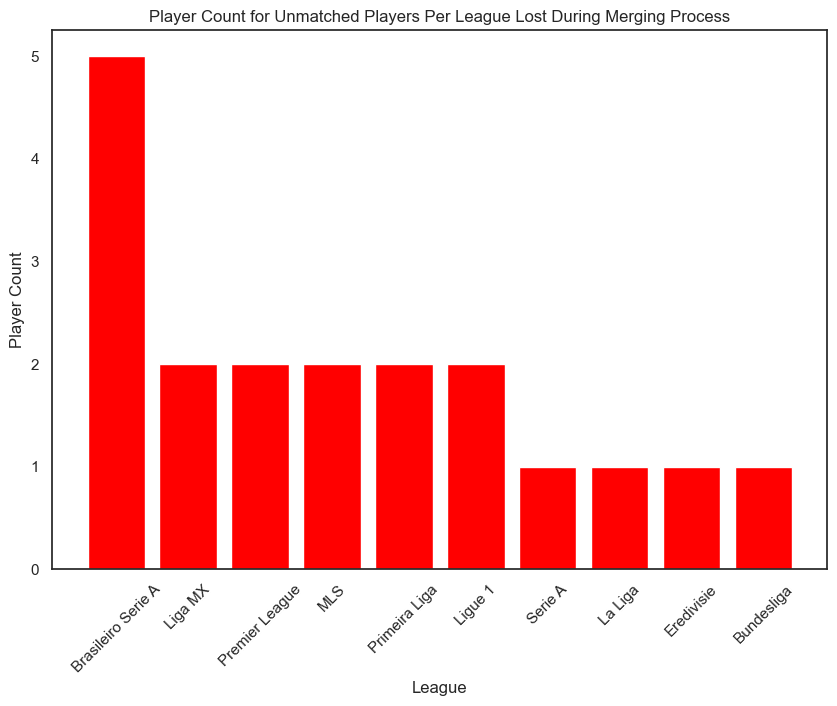

In [357]:
# Barchart plots players count for each league
unmatched_counts = (unmatched_df['Comp Level'].value_counts().to_dict())

plt.figure(figsize=(10, 7))
plt.bar(range(len(unmatched_counts)), list(unmatched_counts.values()), align='center', color='red')
plt.xticks(range(len(unmatched_counts)), list(unmatched_counts.keys()), rotation = 45)
plt.xlabel('League')
plt.ylabel('Player Count')
plt.title('Player Count for Unmatched Players Per League Lost During Merging Process')
plt.show()

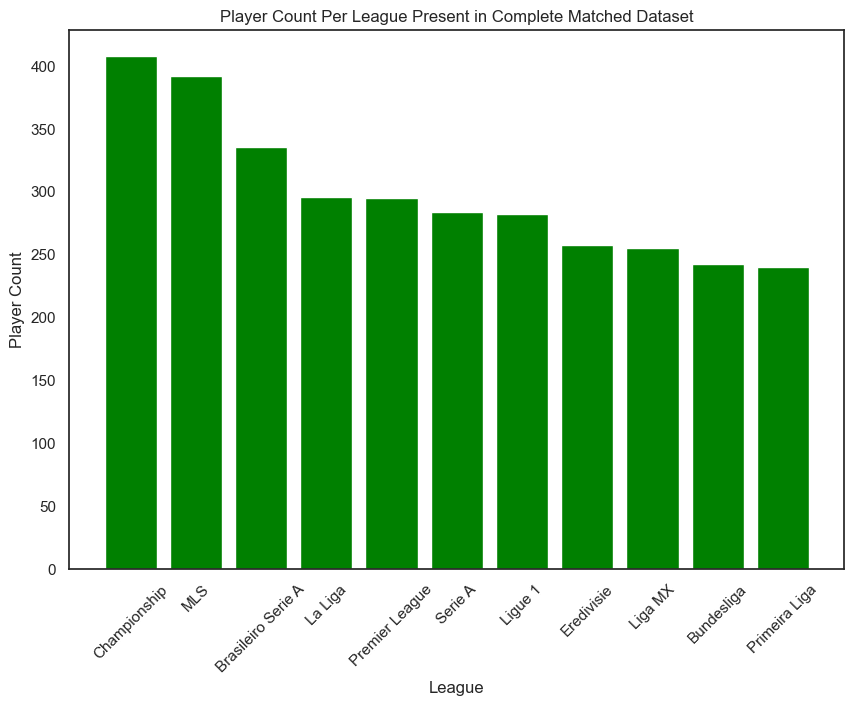

In [358]:
# Barchart plots players count for each league
original_counts = (complete_data['Comp Level'].value_counts().to_dict())

plt.figure(figsize=(10, 7))
plt.bar(range(len(original_counts)), list(original_counts.values()), align='center', color='green')
plt.xticks(range(len(original_counts)), list(original_counts.keys()), rotation = 45)
plt.xlabel('League')
plt.ylabel('Player Count')
plt.title('Player Count Per League Present in Complete Matched Dataset')
plt.show()

## Retrieve Random Manual Test Data

In [360]:
manual_test = complete_data.sample(n=100, random_state=20)
complete_data = complete_data.drop(manual_test.index)

manual_test = manual_test.reset_index(drop=True)
manual_test.to_csv('maual_test.csv')

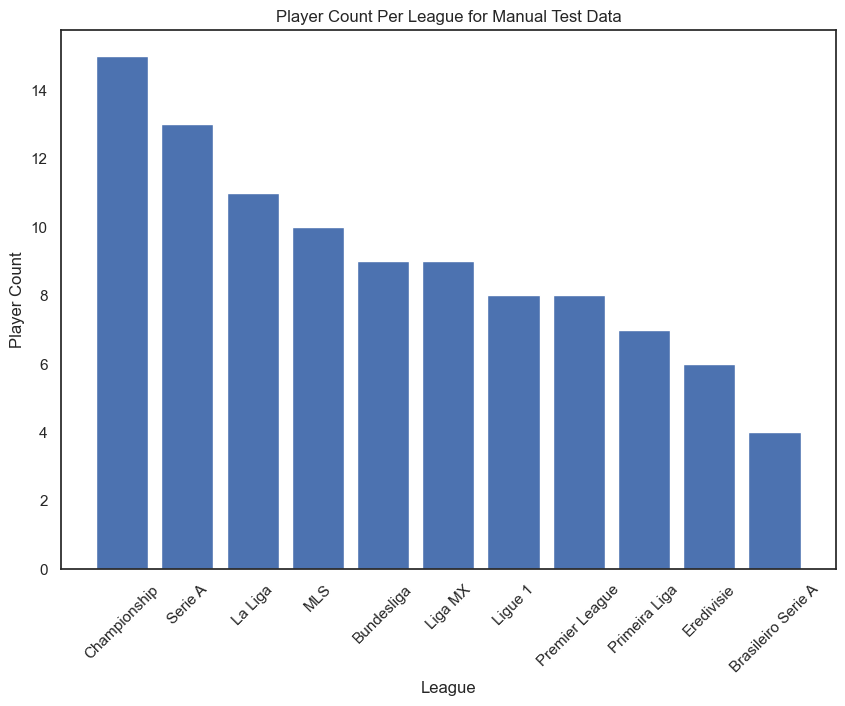

In [361]:
# Barchart plots players count for each league
original_counts = (manual_test['Comp Level'].value_counts().to_dict())

plt.figure(figsize=(10, 7))
plt.bar(range(len(original_counts)), list(original_counts.values()), align='center')
plt.xticks(range(len(original_counts)), list(original_counts.keys()), rotation = 45)
plt.xlabel('League')
plt.ylabel('Player Count')
plt.title('Player Count Per League for Manual Test Data')
plt.show()

## Feature Selection

In [363]:
# Filter dataframe to only include outfield players with large sample
# size of games played
season_stats = complete_data[complete_data['Minutes 90S'] > 10]
season_stats = complete_data[complete_data['Position'] != 'GK']
season_stats = complete_data[complete_data['sub_position'] != 'Goalkeeper']
season_stats = season_stats.reset_index(drop=True)

In [367]:
# Retrieve chosen features
features = ['Npxg_Per90',
 'Passes_Per90',
 'Passes Total Distance_Per90',
 'Passes Progressive Distance_Per90',
 'Passes Short_Per90',
 'Passes Pct Short_Per90',
 'Passes Long_Per90',
 'Passes Pct Long_Per90',
 'Assisted Shots_Per90',
 'Passes Into Final Third_Per90',
 'Passes Into Penalty Area_Per90',
 'Crosses Into Penalty Area_Per90',
 'Progressive Passes_Per90',
 'Shots On Target_Per90',
 'Npxg Per Shot_Per90',
 'Xg Net_Per90',
 'Npxg Net_Per90',
 'Through Balls_Per90',
 'Passes Switches_Per90',
 'Crosses_Per90',
 'Sca_Per90',
 'Sca Dribbles_Per90',
 'Sca Shots_Per90',
 'Sca Fouled_Per90',
 'Sca Defense_Per90',
 'Tackles_Per90',
 'Tackles Def 3Rd_Per90',
 'Tackles Mid 3Rd_Per90',
 'Tackles Att 3Rd_Per90',
 'Dribble Tackles_Per90',
 'Dribbles Vs_Per90',
 'Dribble Tackles Pct_Per90',
 'Blocks_Per90',
 'Blocked Shots_Per90',
 'Blocked Passes_Per90',
 'Interceptions_Per90',
 'Tackles Interceptions_Per90',
 'Clearances_Per90',
 'Touches_Per90',
 'Touches Def Pen Area_Per90',
 'Touches Def 3Rd_Per90',
 'Touches Mid 3Rd_Per90',
 'Touches Att 3Rd_Per90',
 'Touches Att Pen Area_Per90',
 'Dribbles_Per90',
 'Passes Received_Per90',
 'Progressive Passes Received_Per90'
           ]

features_df = season_stats[features]

In [368]:
# Show chosen features
print('Number of chosen features: ', len(features))
print(' ')
print(','.join(features))

Number of chosen features:  47
 
Npxg_Per90,Passes_Per90,Passes Total Distance_Per90,Passes Progressive Distance_Per90,Passes Short_Per90,Passes Pct Short_Per90,Passes Long_Per90,Passes Pct Long_Per90,Assisted Shots_Per90,Passes Into Final Third_Per90,Passes Into Penalty Area_Per90,Crosses Into Penalty Area_Per90,Progressive Passes_Per90,Shots On Target_Per90,Npxg Per Shot_Per90,Xg Net_Per90,Npxg Net_Per90,Through Balls_Per90,Passes Switches_Per90,Crosses_Per90,Sca_Per90,Sca Dribbles_Per90,Sca Shots_Per90,Sca Fouled_Per90,Sca Defense_Per90,Tackles_Per90,Tackles Def 3Rd_Per90,Tackles Mid 3Rd_Per90,Tackles Att 3Rd_Per90,Dribble Tackles_Per90,Dribbles Vs_Per90,Dribble Tackles Pct_Per90,Blocks_Per90,Blocked Shots_Per90,Blocked Passes_Per90,Interceptions_Per90,Tackles Interceptions_Per90,Clearances_Per90,Touches_Per90,Touches Def Pen Area_Per90,Touches Def 3Rd_Per90,Touches Mid 3Rd_Per90,Touches Att 3Rd_Per90,Touches Att Pen Area_Per90,Dribbles_Per90,Passes Received_Per90,Progressive Passes

# PCA and Clustering

In [369]:
# Normalize selected features for PCA
x = features_df.values
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

In [370]:
# Apply PCA to normalized data
pca = PCA(n_components = 2)
reduced = pd.DataFrame(pca.fit_transform(X_norm))

## Identifying Optimim Clusters

#### Elbow Method

In [371]:
# Calculate some of square differences for 10 clusters
sum_of_squared_distance_values = []
k_range = range(1,10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km = km.fit(reduced)
    sum_of_squared_distance_values.append(km.inertia_)

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_i

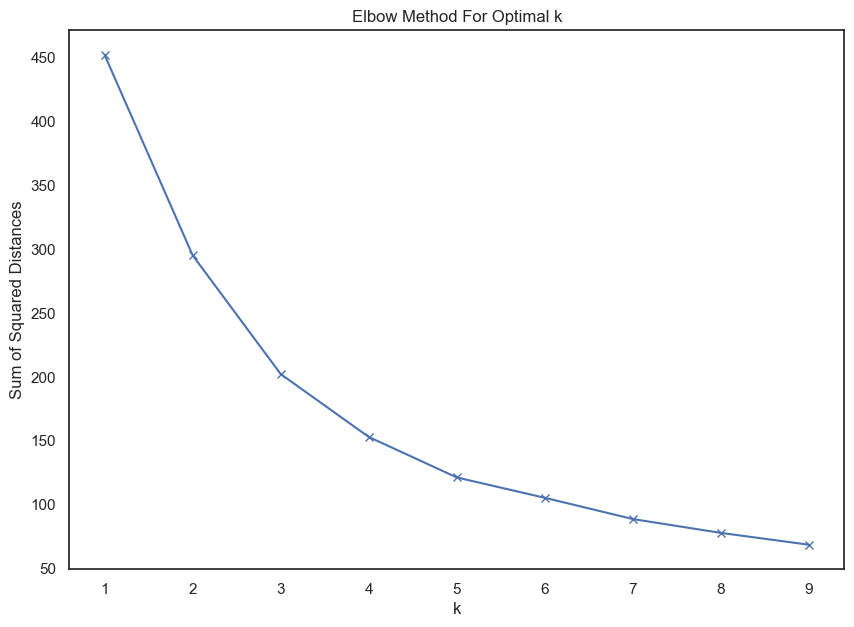

In [372]:
# Line Plot for results
plt.figure(figsize=(10, 7))
plt.plot(k_range, sum_of_squared_distance_values, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#### Silhouette Method

In [373]:
# Calculate some of sillhouette score for 10 clusters
silhouette_values = []
k_range = range(2,10)

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in k_range:
    kmeans = KMeans(n_clusters = k).fit(reduced)
    labels = kmeans.labels_
    silhouette_values.append(silhouette_score(reduced, labels, metric = 'euclidean'))

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_i

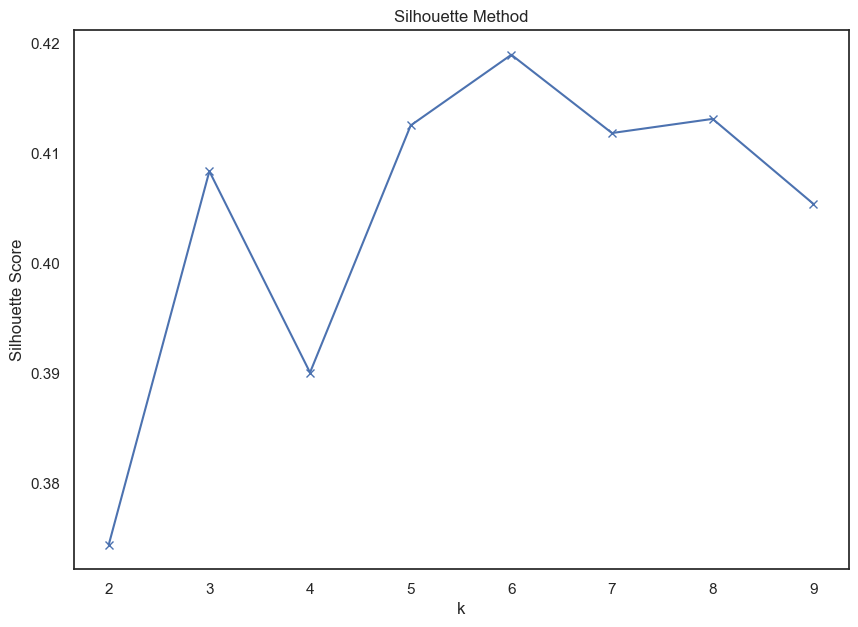

In [374]:
# Line Plot for results
plt.figure(figsize=(10, 7))
plt.plot(k_range, silhouette_values, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

In [375]:
# Create cluster using identified optimum number of clusters
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(reduced)
labels = kmeans.predict(reduced)
centroid = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [376]:
# Apply labels to reduced dataframe
reduced['cluster'] = clusters

# Add player names to reduced dataframe from complete dataset
reduced['player'] = season_stats['Player']
reduced.columns = ['x', 'y', 'cluster', 'name']

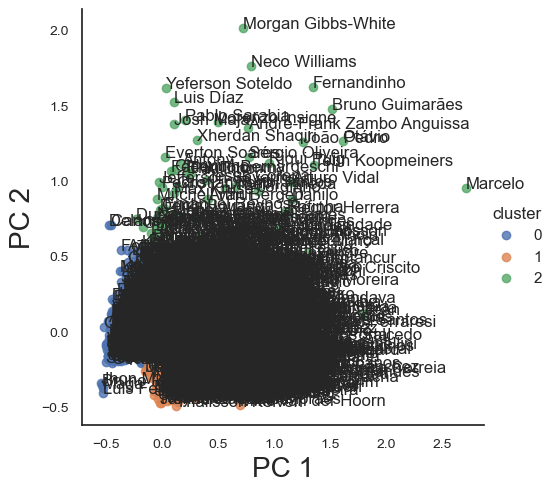

In [377]:
# Plot scatterplot of clusters
sns.set(style="white")
ax = sns.lmplot(x="x", 
                y="y", 
                hue='cluster', 
                data = reduced, 
                fit_reg=False,  
#                 scatter_kws={"s": 250}
               )

texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.name):
    texts.append(plt.text(x, y, s))
    plt.tick_params(labelsize=10)
    plt.xlabel("PC 1", fontsize = 20)
    plt.ylabel("PC 2", fontsize = 20)

plt.show()

### Outlier Detection

In [379]:
# Apply PCA to normalized data
pca = PCA(n_components = 3)
positions = pd.DataFrame(pca.fit_transform(X_norm))

In [380]:
# Encode position strings as integer values
positions['position_category'] = season_stats['position_category']
positions['sub_position'] = season_stats['sub_position']

# Hard code encoding mappings
position_category_encoding = {
    'Defender' : 0,
    'Midfield' : 1,
    'Attack' : 2
}

sub_position_encoding = {
    'Full Back' : 0,
    'Centre-Back' : 1,
    
    'Defensive Midfield': 2,
    'Central Midfield' : 3,
    'Attacking Midfield' : 4,
    
    'Wide Midfield' : 5,
    
    'Winger' : 6,
    
#     'Centre-Forward' : 7,
#     'Second Striker' : 8,
    'Striker': 9
}

position_categories = position_category_encoding.keys()
sub_positions = sub_position_encoding.keys()

# Encode both 'position_category' and 'sub_position' as numbers to be read by KNN algorithm
# positions['position_category'] = [position_category_encoding[position] for position in positions['position_category']]
# positions['sub_position'] = [sub_position_encoding[position] for position in positions['sub_position']]
positions['player'] = season_stats['Player']

,0,1,2,position_category,sub_position,player
0,-0.431567,0.067302,-0.066054,Attack,Striker,Aaron Connolly
1,0.226029,0.034690,0.213567,Defender,Full Back,Aaron Cresswell
2,0.202638,0.027402,0.241885,Defender,Full Back,Aaron Herrera
3,-0.127556,-0.104047,0.019221,Defender,Full Back,Aaron Hickey
4,-0.305947,-0.106268,0.010438,Attack,Winger,Aaron Lennon
...,...,...,...,...,...,...
3173,0.164115,-0.091173,-0.215824,Midfield,Central Midfield,Óscar Valentín
3174,0.118851,0.054415,0.011354,Defender,Full Back,Óscar de Marcos
3175,-0.406665,-0.152889,-0.025785,Midfield,Attacking Midfield,Þorleifur Úlfarsson
3176,0.118825,0.013043,0.095528,Defender,Full Back,Šime Vrsaljko


## Multi Component PCA

In [383]:
# Normalize selected features for PCA
x = features_df.values
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
X_norm = pd.DataFrame(x_scaled)

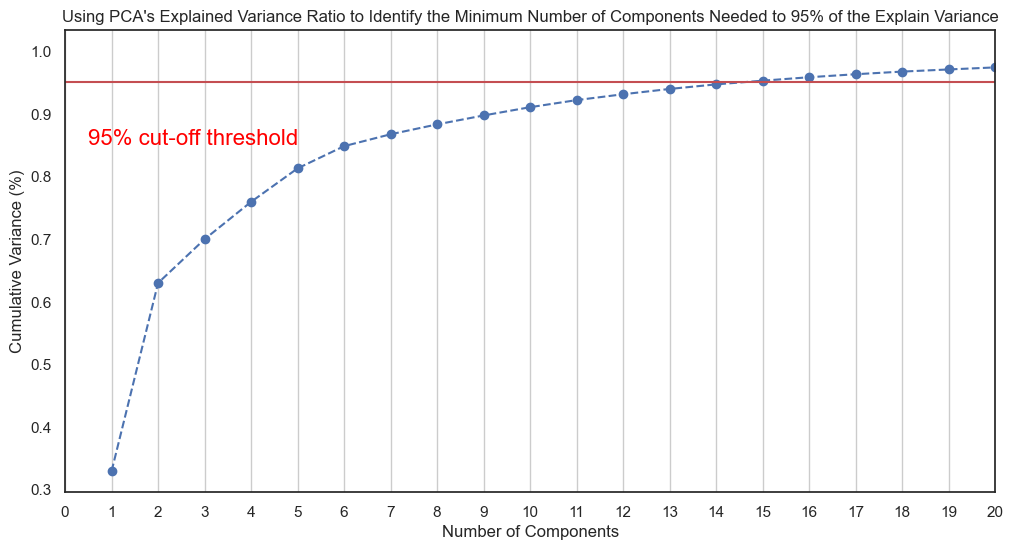

In [384]:
# Identify optimummn number of components to explain 95%
# of datas variance
pca = PCA().fit(X_norm)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, len(features) + 1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 21, step=1))
plt.ylabel('Cumulative Variance (%)')
plt.title("Using PCA's Explained Variance Ratio to Identify the Minimum Number of Components Needed to 95% of the Explain Variance")

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.set_xlim([0, 20])
ax.grid(axis='x')
plt.show()

In [385]:
# Define number of components chosen by graph
num_components = 14
pca = PCA(n_components = num_components)
player_components = pd.DataFrame(pca.fit_transform(X_norm))

In [386]:
# Create correlation matrix to show correlations between components
# and features
result = pd.concat([features_df, player_components], axis=1).corr()
feature_cols = features_df.columns.to_list()
reduced_cols = player_components.columns.to_list()
correlation = result[reduced_cols].loc[feature_cols]

In [387]:
# Split matrix in half to make plotting clearer
num_features = len(features)
midpoint = round(num_features / 2)

half1 = correlation.iloc[:midpoint,:]
half2 = correlation.iloc[midpoint:,:]

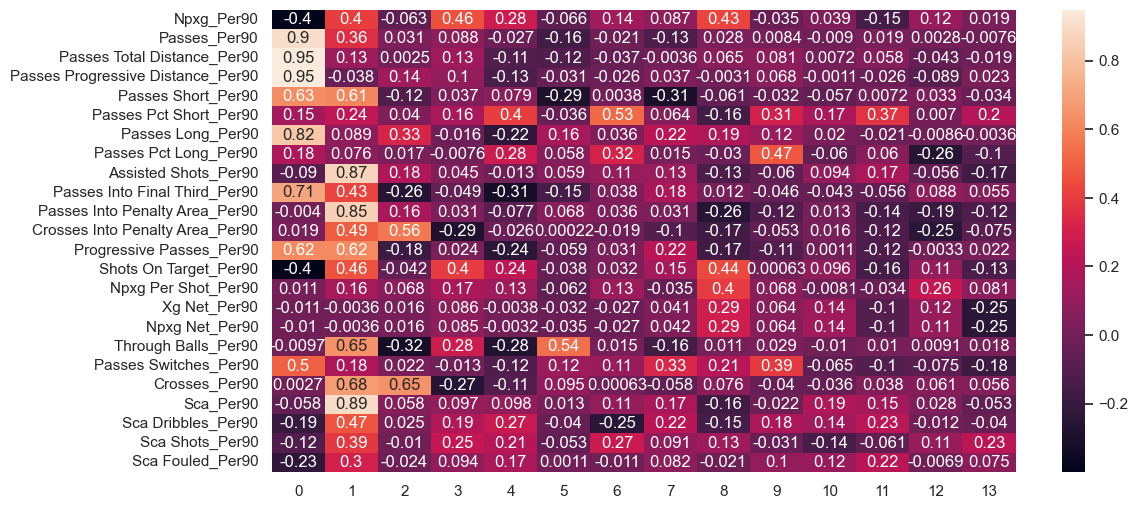

In [388]:
# Plot1
sns.heatmap(half1, annot=True)
plt.show()

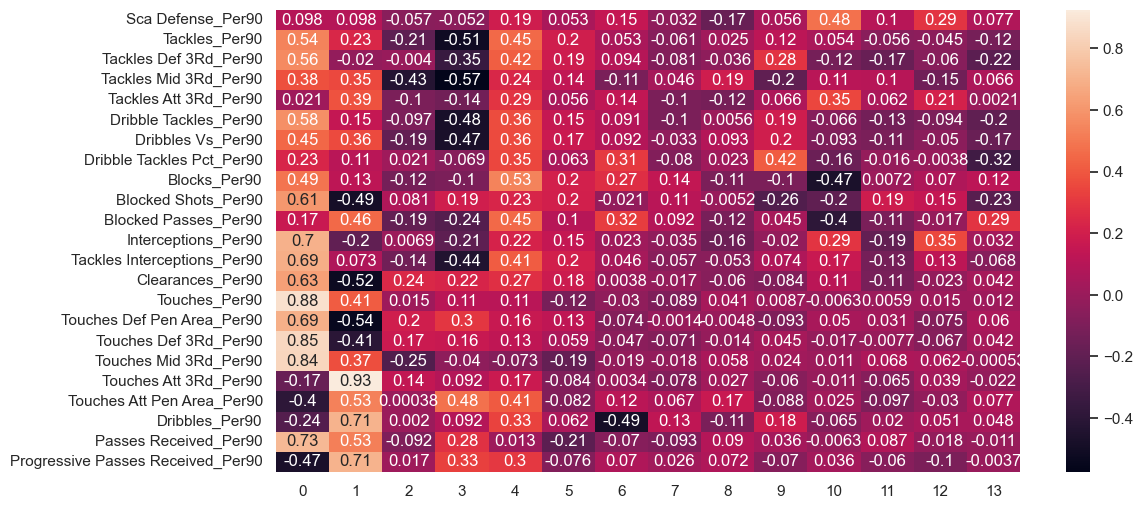

In [389]:
# Plot2
sns.heatmap(half2, annot=True)
plt.show()

In [390]:
correlation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Npxg_Per90,-0.395123,0.404132,-0.062957,0.456278,0.276584,-0.065814,0.138252,0.086555,0.425543,-0.034734,0.038747,-0.148479,0.120709,0.018959
Passes_Per90,0.903801,0.355802,0.031183,0.087755,-0.026740,-0.157060,-0.021130,-0.125192,0.028279,0.008401,-0.009021,0.019393,0.002808,-0.007648
Passes Total Distance_Per90,0.948629,0.125470,0.002512,0.127494,-0.112632,-0.116409,-0.036554,-0.003565,0.064508,0.081147,0.007200,0.057898,-0.042858,-0.018809
Passes Progressive Distance_Per90,0.947055,-0.037743,0.138067,0.099989,-0.132983,-0.030763,-0.025994,0.036578,-0.003106,0.067632,-0.001109,-0.026081,-0.089015,0.023352
Passes Short_Per90,0.630765,0.606627,-0.119625,0.036522,0.078557,-0.294546,0.003756,-0.307178,-0.061128,-0.032359,-0.057203,0.007229,0.033132,-0.034072
Passes Pct Short_Per90,0.145306,0.239606,0.040074,0.163505,0.404724,-0.036116,0.526016,0.063927,-0.160714,0.305968,0.174425,0.374588,0.006961,0.198456
Passes Long_Per90,0.818431,0.088723,0.327407,-0.016146,-0.220208,0.160331,0.035718,0.221574,0.186913,0.123017,0.020432,-0.020693,-0.008608,-0.003632
Passes Pct Long_Per90,0.176860,0.075791,0.016926,-0.007570,0.276871,0.058304,0.315573,0.014895,-0.029910,0.469985,-0.059712,0.059693,-0.261140,-0.101554
Assisted Shots_Per90,-0.089563,0.867149,0.180910,0.045160,-0.012824,0.059248,0.111293,0.126739,-0.125342,-0.060045,0.093561,0.167823,-0.055707,-0.167594
Passes Into Final Third_Per90,0.709643,0.427119,-0.263672,-0.048576,-0.314882,-0.147144,0.037594,0.179107,0.011930,-0.046035,-0.042601,-0.056488,0.088195,0.055278


In [391]:
# player_components.columns = [str(num) for num in range(0, player_components.shape[1])]
player_components['player'] = season_stats['Player']
s21_22['player'] = s21_22['Player']
# player_search_df = pd.merge(s21_22, player_components, on=['player'], how='outer').dropna().reset_index(drop=True)
player_info = pd.merge(s21_22, player_components, on=['player'], how='outer').dropna().reset_index(drop=True)
player_info = player_info[s21_22.columns.to_list()]
# player_search_df.drop(['Player'], axis=1, inplace=True)

In [393]:
# Testing Euclidean Distance Calculation on Target Player
euclidean_similar_players('Cristiano Ronaldo', player_components)

,player,value
0,Cristiano Ronaldo,0.0000
1,Ciro Immobile,0.0724
2,Aleksandar Mitrović,0.1026
3,Sehrou Guirassy,0.1063
4,Kévin Gameiro,0.1183
5,Steven Fletcher,0.1191
6,Sébastien Haller,0.1193
7,Ian Gonzalez Nieto,0.1439
8,Fernando Aristeguieta,0.1439
9,Sasa Kalajdzic,0.1440


In [394]:
original_vector_space = player_components.copy()

In [397]:
# Add positional columns to 'player_components' data 
player_components['position_category'] = season_stats['position_category']
player_components['sub_position'] = season_stats['sub_position']

# Hard code encoding mappings
position_category_encoding = {
    'Defender' : 0,
    'Midfield' : 1,
    'Attack' : 2
}

sub_position_encoding = {
    'Full Back' : 0,
    'Centre-Back' : 1,
    
    'Defensive Midfield': 2,
    'Central Midfield' : 3,
    'Attacking Midfield' : 4,
    
    'Wide Midfield' : 5,
    
    'Winger' : 6,
    
    'Striker': 7
}

position_categories = position_category_encoding.keys()
sub_positions = sub_position_encoding.keys()

# Drop any nan values that are not necessary in dataframe
player_components = player_components.dropna()

# Encode both 'position_category' and 'sub_position' as numbers to be read by KNN algorithm
player_components['position_category'] = [position_category_encoding[position] for position in player_components['position_category']]
player_components['sub_position'] = [sub_position_encoding[position] for position in player_components['sub_position']]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,player,position_category,sub_position
0,-0.431567,0.067302,-0.066053,0.165925,0.128487,-0.099111,0.106842,0.065651,0.024180,0.022304,-0.083282,-0.026901,0.012619,0.066913,Aaron Connolly,2,9
1,0.226029,0.034690,0.213567,0.009058,-0.124882,-0.126981,0.014711,-0.049115,-0.002425,-0.033898,-0.056599,0.023405,0.067260,-0.002650,Aaron Cresswell,0,0
2,0.202638,0.027402,0.241885,-0.035128,-0.066559,0.021072,0.004767,0.063991,-0.010283,-0.003646,-0.034936,-0.032354,0.000693,-0.039377,Aaron Herrera,0,0
3,-0.127556,-0.104047,0.019221,-0.024537,0.034529,-0.032548,-0.018434,-0.101317,-0.024426,-0.007087,-0.042474,0.033275,0.027951,-0.023744,Aaron Hickey,0,0
4,-0.305947,-0.106268,0.010438,-0.140221,0.081235,0.004710,0.014331,-0.008935,0.002876,-0.011354,-0.052345,0.040998,0.024768,0.034833,Aaron Lennon,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,0.164115,-0.091173,-0.215824,-0.256862,0.062186,-0.008426,0.030318,0.084875,0.038997,-0.032175,-0.016401,0.001348,-0.038339,0.028387,Óscar Valentín,1,3
3174,0.118851,0.054415,0.011354,-0.141259,0.006333,-0.106204,0.026721,-0.072270,-0.009992,-0.025027,0.003118,-0.024336,-0.045930,-0.013337,Óscar de Marcos,0,0
3175,-0.406665,-0.152889,-0.025785,0.062917,0.064925,-0.006004,0.060468,-0.011741,0.067884,-0.023393,0.026399,-0.011583,-0.016050,-0.032022,Þorleifur Úlfarsson,1,4
3176,0.118825,0.013043,0.095528,-0.172960,0.036767,-0.055903,0.000718,-0.126367,0.047287,-0.039981,0.018155,-0.027336,-0.023964,0.064308,Šime Vrsaljko,0,0


In [399]:
# Abreviate sub_positions for easy labelling of charts
abreviated = []

for position in list(sub_positions):
    position_split = ''
    if len(position.split(' ')) == 1:
        new_position = position[0]
        
    if '-' in position:
        position_split = position.split('-')
        
    elif ' ' in position:
        position_split = position.split(' ')
    
    if position_split:
        new_position = position_split[0][0] + position_split[1][0]
    
    abreviated.append(new_position)

In [401]:
# Split data with a test size of 20%
split = int(len(player_components) * 0.8)
train_df = player_components[:split]
test_df = player_components[split:]

# KNN Classifier

## Position Category Predictions

In [402]:
# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['position_category']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['position_category']

In [403]:
# Identify ideal K value
k = []
error_rate = []
accuracies = []
for val in range(1,25):
    # Define and fit KNN classifier
    knn_clf=KNeighborsClassifier(n_neighbors=val)
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    k.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = k[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = k[best_error_rate] 

Text(9, 0.85, 'Best Accuracy (23)')

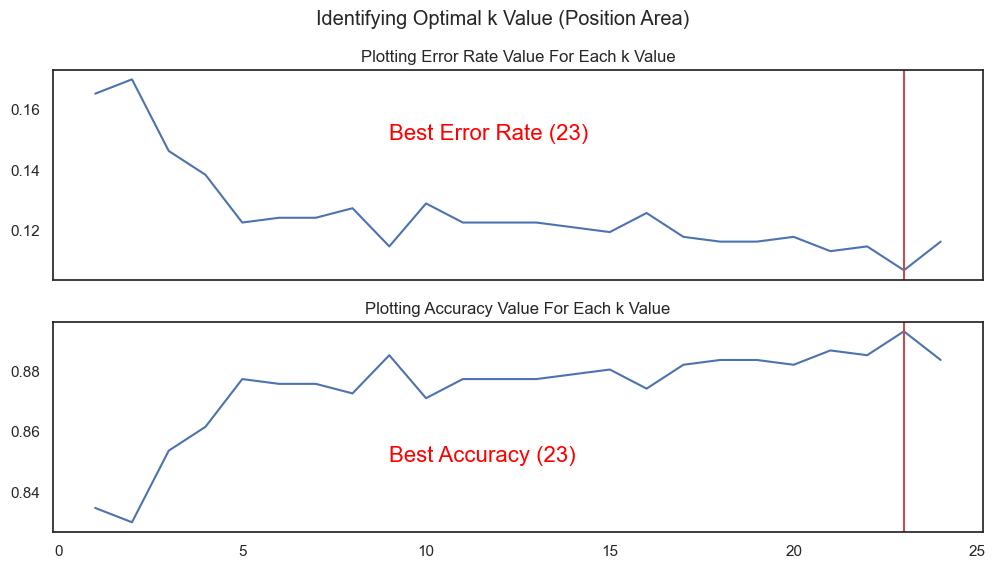

In [404]:
# Plot accuracy and error rate values
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal K Value for K-Nearest Neighbour Model (Position Area)')

ax1.plot(k, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(9, 0.15, f'Best Error Rate ({best_k_error_rate})', color = 'red', fontsize=16)

ax2.plot(k, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(9, 0.85, f'Best Accuracy ({best_k_accuracy})', color = 'red', fontsize=16)

In [405]:
# Define and fit KNN classifier
original_category_knn=KNeighborsClassifier(n_neighbors=best_k_error_rate)
original_category_knn.fit(x_train,y_train)
ypred=original_category_knn.predict(x_test) #These are the predicted output values

In [406]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=position_categories)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

    Defender       0.93      0.96      0.95       249
    Midfield       0.87      0.84      0.86       212
      Attack       0.86      0.86      0.86       175

    accuracy                           0.89       636
   macro avg       0.89      0.89      0.89       636
weighted avg       0.89      0.89      0.89       636

Accuracy: 0.8930817610062893


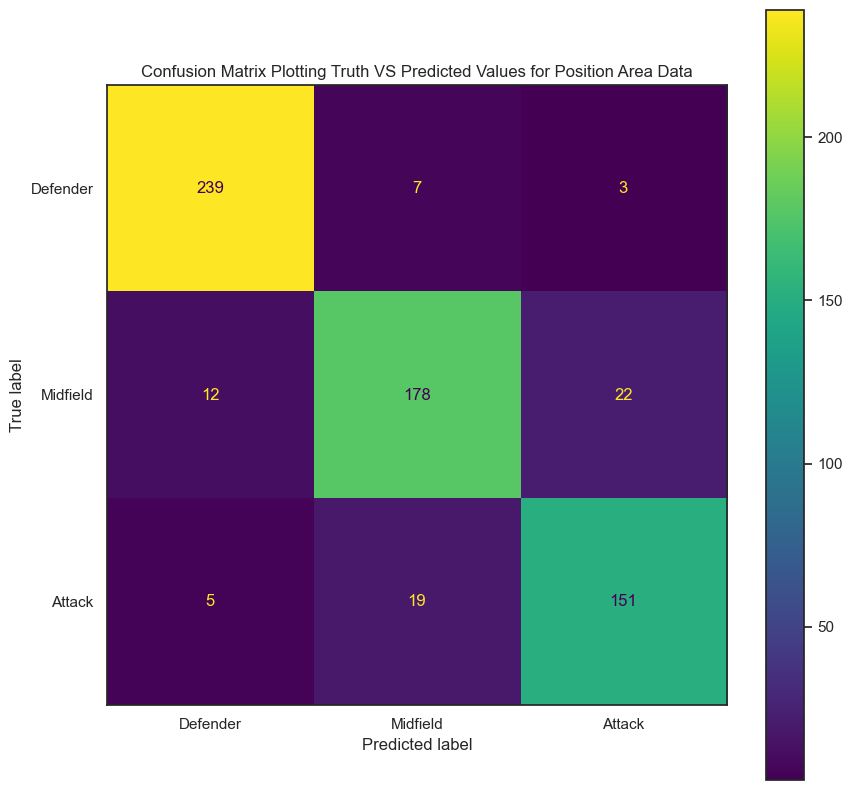

In [407]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=list(position_categories)
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Position Area)')
cm_display.plot(ax=ax)

## Sub Position Predictions

In [408]:
# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['sub_position']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['sub_position']

In [409]:
# Identify ideal K value
k = []
error_rate = []
accuracies = []
for val in range(1,25):
    # Define and fit KNN classifier
    knn_clf=KNeighborsClassifier(n_neighbors=val)
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    k.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = k[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = k[best_error_rate] 

Text(9, 0.68, 'Best Accuracy (22)')

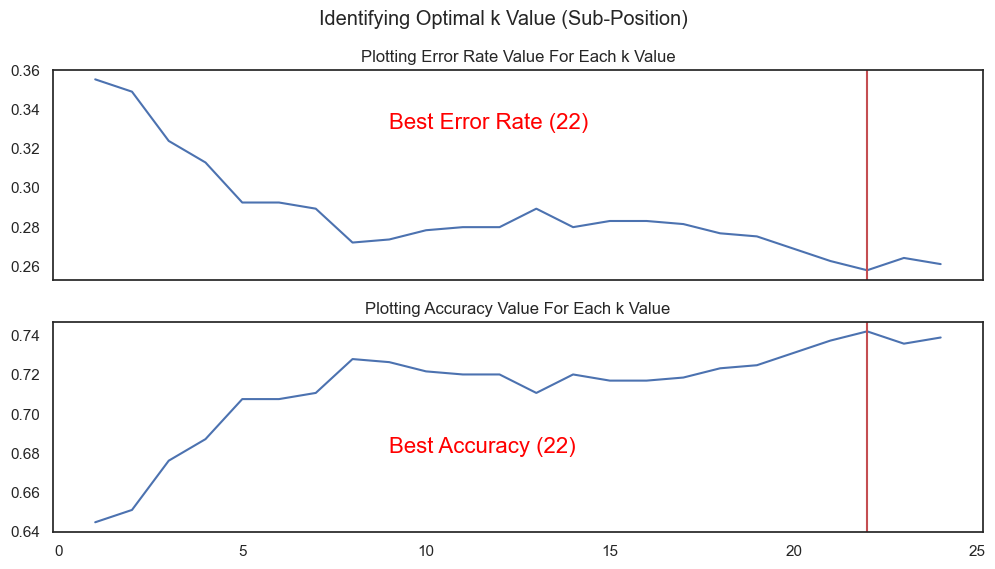

In [410]:
# Plot accuracy and error rate values
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal K Value for K-Nearest Neighbour Model (Sub-Position)')

ax1.plot(k, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(9, 0.33, f'Best Error Rate ({best_k_error_rate})', color = 'red', fontsize=16)

ax2.plot(k, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(9, 0.68, f'Best Accuracy ({best_k_accuracy})', color = 'red', fontsize=16)

In [411]:
# Define and fit KNN classifier
original_sub_knn=KNeighborsClassifier(n_neighbors=best_k_error_rate)
original_sub_knn.fit(x_train,y_train)
ypred=original_sub_knn.predict(x_test) #These are the predicted output values

In [412]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=sub_positions)
print('Classification Report:',)
print (report)
accuracy = accuracy_score(y_test,ypred)
print('Accuracy:',accuracy)

Classification Report:
                    precision    recall  f1-score   support

         Full Back       0.80      0.89      0.84       106
       Centre-Back       0.93      0.95      0.94       143
Defensive Midfield       0.52      0.55      0.53        58
  Central Midfield       0.64      0.58      0.61       105
Attacking Midfield       0.35      0.20      0.25        41
     Wide Midfield       0.00      0.00      0.00         8
            Winger       0.65      0.75      0.69        80
           Striker       0.84      0.85      0.84        95

          accuracy                           0.74       636
         macro avg       0.59      0.60      0.59       636
      weighted avg       0.72      0.74      0.73       636

Accuracy: 0.7421383647798742


C:\Users\tomca\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\tomca\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



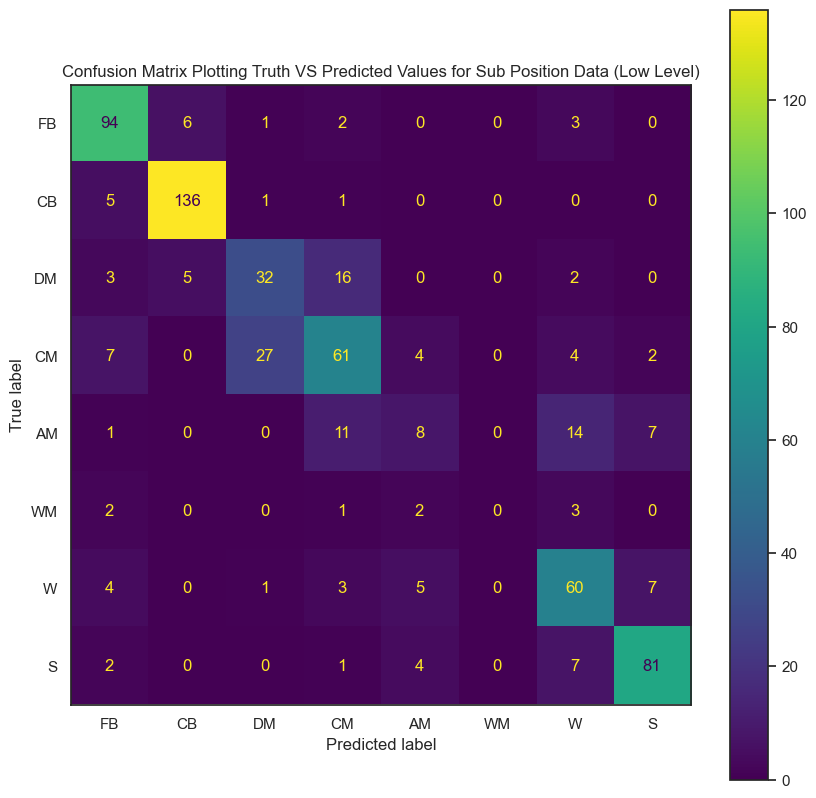

In [413]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=abreviated
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Sub Position)')
cm_display.plot(ax=ax)

In [414]:
# Calculate scatter
scatter = test_df.copy()
scatter['cluster'] = y_pred
scatter = scatter.drop(['player', 'position_category', 'sub_position'], axis=1)
cluster_means = scatter.groupby('cluster').mean()
scatter['ssd'] = scatter.apply(lambda row: ((row.iloc[:-2] - cluster_means.loc[row['cluster']]) ** 2).sum(), axis=1)
ssd_by_cluster = scatter.groupby('cluster')['ssd'].sum()
overall_ssd = ssd_by_cluster.sum()
overall_ssd

66.57324908754065

## SVM

### Position Area

In [424]:
# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['position_category']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['position_category']

In [425]:
# Identify ideal C value
C = []
error_rate = []
accuracies = []
for val in range(1,100):
    # Define and fit KNN classifier
    knn_clf=SVC(C=val, random_state=1, kernel='rbf')
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    C.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = C[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = C[best_error_rate] 

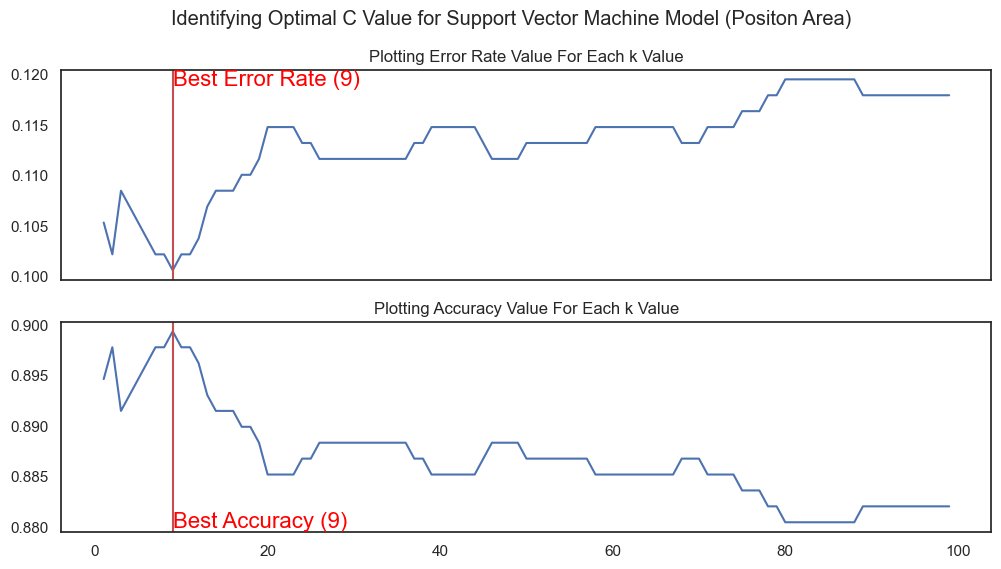

In [426]:
# Plot accuracy and error rate values
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal C Value for Support Vector Machine Model (Positon Area)')

ax1.plot(C, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(best_k_error_rate, ax1.get_ylim()[1], f'Best Error Rate ({best_k_error_rate})', color='red', fontsize=16,
         verticalalignment='top')

ax2.plot(C, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(best_k_accuracy, ax2.get_ylim()[0], f'Best Accuracy ({best_k_accuracy})', color='red', fontsize=16,
         verticalalignment='bottom')

plt.show()

In [427]:
# Instantiate the Support Vector Classifier (SVC)
original_category_svc = SVC(C=9, random_state=1, kernel='rbf')
# svc = SVC(C=14, random_state=1, kernel='linear', probability=True)
 
# Fit the model
original_category_svc.fit(x_train, y_train)
# Make the predictions
ypred = original_category_svc.predict(x_test)

In [428]:
# Output confusion matrix
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=position_categories)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

    Defender       0.94      0.96      0.95       249
    Midfield       0.90      0.82      0.86       212
      Attack       0.85      0.91      0.88       175

    accuracy                           0.90       636
   macro avg       0.89      0.90      0.89       636
weighted avg       0.90      0.90      0.90       636

Accuracy: 0.89937106918239


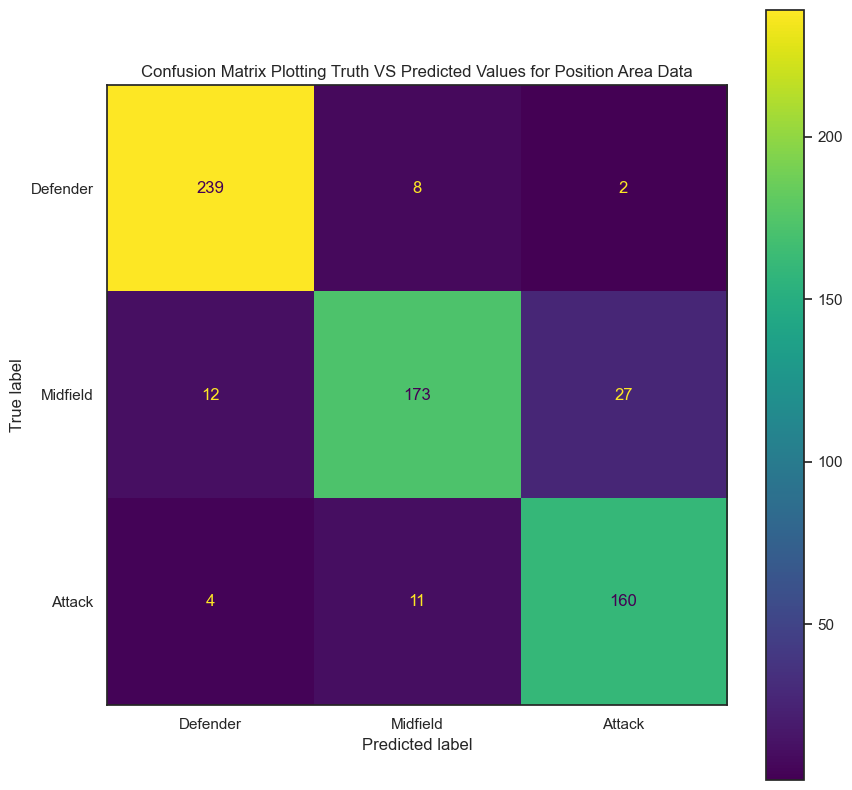

In [429]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=list(position_categories)
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for Position Area Data')
cm_display.plot(ax=ax)

## Sub position

In [434]:
# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['sub_position']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['sub_position']

In [435]:
# Identify ideal C value
C = []
error_rate = []
accuracies = []
for val in range(1,100):
    # Define and fit KNN classifier
    knn_clf=SVC(C=val, random_state=1, kernel='rbf')
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    C.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = C[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = C[best_error_rate] 

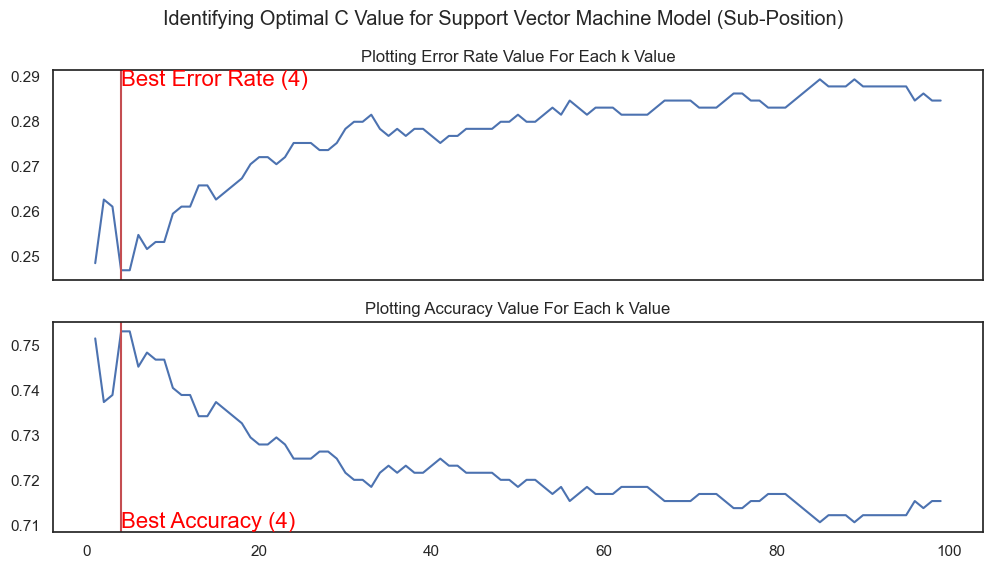

In [436]:
# Plot accuracy and error rate values
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal C Value for Support Vector Machine Model (Sub-Position)')

ax1.plot(C, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(best_k_error_rate, ax1.get_ylim()[1], f'Best Error Rate ({best_k_error_rate})', color='red', fontsize=16,
         verticalalignment='top')

ax2.plot(C, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(best_k_accuracy, ax2.get_ylim()[0], f'Best Accuracy ({best_k_accuracy})', color='red', fontsize=16,
         verticalalignment='bottom')

plt.show()

In [437]:
# Define model
original_sub_svc = SVC(C=4, random_state=4, kernel='rbf')
 
# Fit the model
original_sub_svc.fit(x_train, y_train)

ypred = original_sub_svc.predict(x_test)

In [438]:
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       106
           1       0.91      0.97      0.94       143
           2       0.53      0.59      0.56        58
           3       0.66      0.54      0.60       105
           4       0.39      0.27      0.32        41
           5       0.00      0.00      0.00         8
           6       0.61      0.84      0.71        80
           9       0.91      0.85      0.88        95

    accuracy                           0.75       636
   macro avg       0.61      0.61      0.61       636
weighted avg       0.74      0.75      0.74       636

Accuracy: 0.7531446540880503


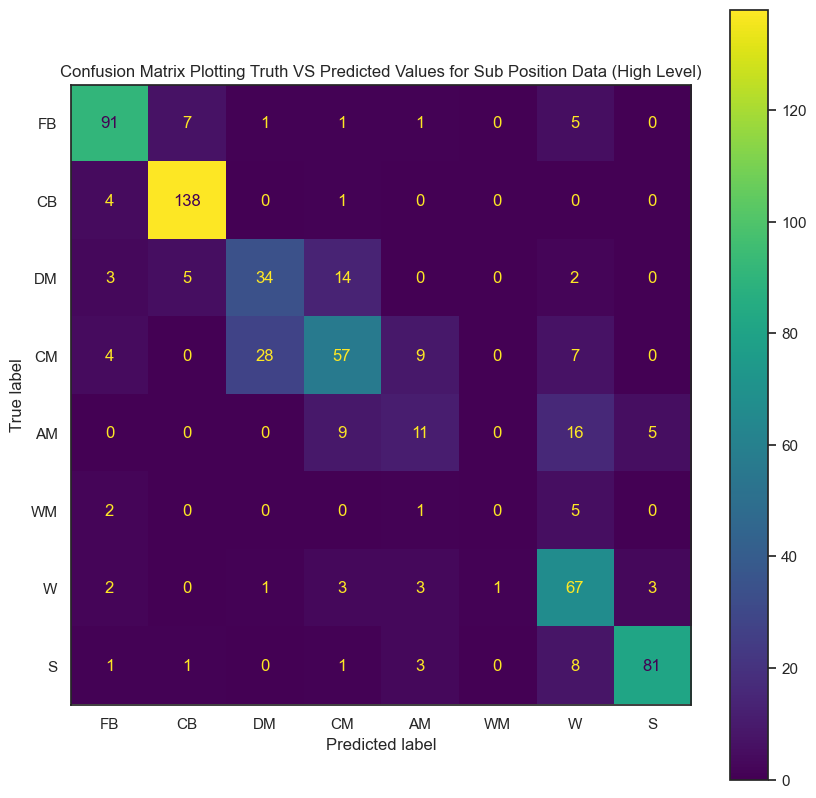

In [439]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=abreviated
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for Support Vector Machine (Sub Position)')
cm_display.plot(ax=ax)

In [440]:
scatter = test_df.copy()
scatter['cluster'] = y_pred
scatter = scatter.drop(['player', 'position_category', 'sub_position'], axis=1)
cluster_means = scatter.groupby('cluster').mean()
scatter['ssd'] = scatter.apply(lambda row: ((row.iloc[:-2] - cluster_means.loc[row['cluster']]) ** 2).sum(), axis=1)
ssd_by_cluster = scatter.groupby('cluster')['ssd'].sum()
overall_ssd = ssd_by_cluster.sum()
overall_ssd

71.74588903615566

In [446]:
# Create high-level vector space using svm model
complete = player_components[[i for i in range(0,14)]]
high_level_svc = SVC(C=4, random_state=1, kernel='rbf', probability=True)
high_level_svc.fit(x_train, y_train)
prob = high_level_svc.predict_proba(complete)
svc_vectors = pd.DataFrame(prob)

In [447]:
svc_vectors

,0,1,2,3,4,5,6,7
0,0.000241,0.002057,0.000316,0.000155,0.012074,0.000363,0.004840,0.979954
1,0.960895,0.015328,0.005656,0.004544,0.000695,0.003499,0.004963,0.004421
2,0.911285,0.060941,0.005037,0.006487,0.000379,0.004244,0.010128,0.001500
3,0.847669,0.015445,0.024981,0.042314,0.008279,0.022118,0.031924,0.007270
4,0.020882,0.008770,0.040617,0.324283,0.076925,0.024628,0.444787,0.059108
...,...,...,...,...,...,...,...,...
3173,0.012599,0.005678,0.827278,0.129193,0.010110,0.001945,0.009507,0.003689
3174,0.964017,0.004077,0.006329,0.009557,0.002371,0.006615,0.006742,0.000292
3175,0.003938,0.002962,0.001384,0.001219,0.004285,0.000747,0.025962,0.959504
3176,0.989175,0.005237,0.000667,0.000719,0.000267,0.002519,0.001265,0.000151


In [449]:
# Apply player name and position labels to vector space
svc_vectors['player'] = season_stats['Player']
high_level_vector_space = svc_vectors.copy()
high_level = svc_vectors
high_level['position_category'] = season_stats['position_category']
high_level['sub_position'] = season_stats['sub_position']
high_level['position_category'] = [position_category_encoding[position] for position in high_level['position_category']]
high_level['sub_position'] = [sub_position_encoding[position] for position in high_level['sub_position']]
high_level

In [451]:
# Split data with a test size of 20%
split = int(len(player_components) * 0.8)
train_df = high_level[:split]
test_df = high_level[split:]

# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['position_category']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['position_category']

In [452]:
k = []
error_rate = []
accuracies = []
for val in range(1,25):
    # Define and fit KNN classifier
    knn_clf=KNeighborsClassifier(n_neighbors=val)
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    k.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = k[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = k[best_error_rate] 

Text(9, 0.85, 'Best Accuracy (4)')

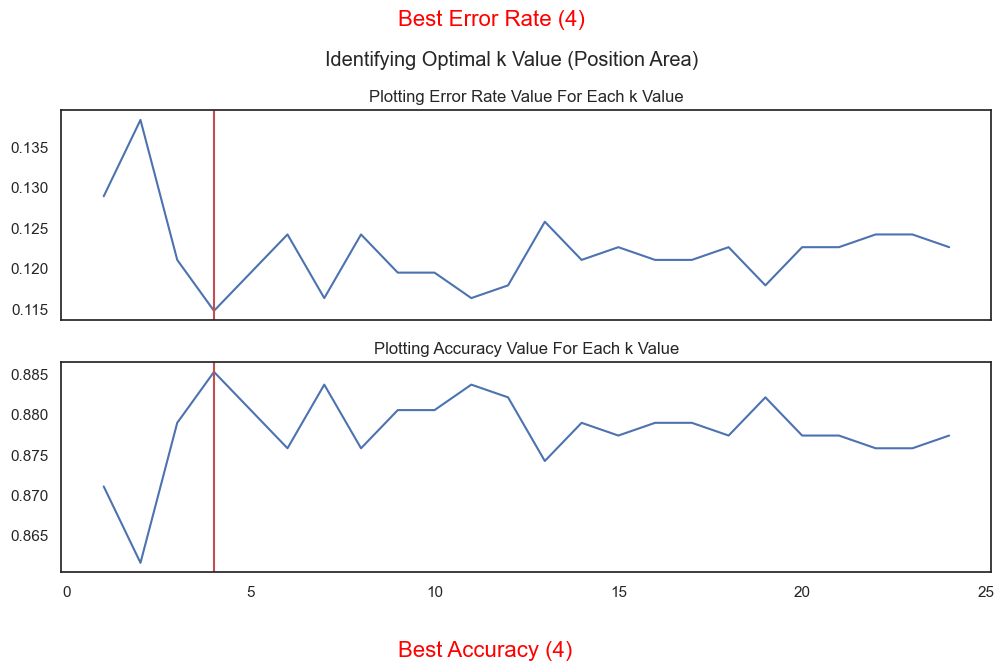

In [453]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal k Value (Position Area)')

ax1.plot(k, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(9, 0.15, f'Best Error Rate ({best_k_error_rate})', color = 'red', fontsize=16)

ax2.plot(k, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(9, 0.85, f'Best Accuracy ({best_k_accuracy})', color = 'red', fontsize=16)

In [454]:
# Define and fit KNN classifier
high_level_category_knn=KNeighborsClassifier(n_neighbors=best_k_error_rate)
high_level_category_knn.fit(x_train,y_train)
ypred=high_level_category_knn.predict(x_test) #These are the predicted output values

In [455]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=position_categories)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

    Defender       0.94      0.96      0.95       249
    Midfield       0.87      0.82      0.84       212
      Attack       0.82      0.86      0.84       175

    accuracy                           0.89       636
   macro avg       0.88      0.88      0.88       636
weighted avg       0.89      0.89      0.88       636

Accuracy: 0.8852201257861635


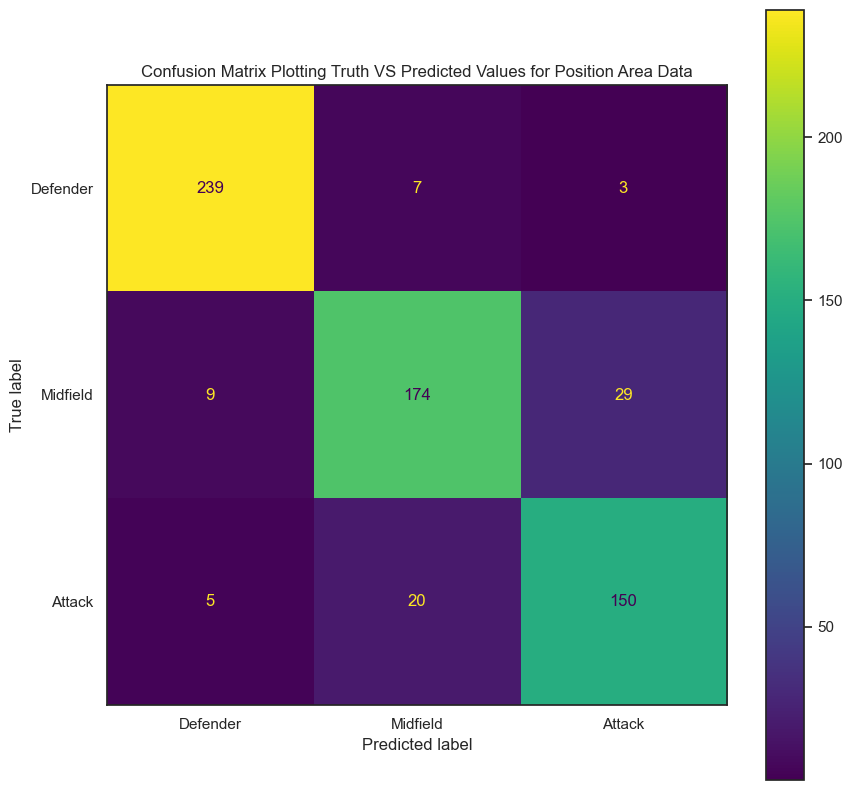

In [456]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=list(position_categories)
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Posiotn Area)')
cm_display.plot(ax=ax)

In [457]:
scatter = test_df.copy()
scatter['cluster'] = y_pred
scatter = scatter.drop(['player', 'position_category', 'sub_position'], axis=1)
cluster_means = scatter.groupby('cluster').mean()
scatter['ssd'] = scatter.apply(lambda row: ((row.iloc[:-2] - cluster_means.loc[row['cluster']]) ** 2).sum(), axis=1)
ssd_by_cluster = scatter.groupby('cluster')['ssd'].sum()
overall_ssd = ssd_by_cluster.sum()
overall_ssd

138.35387991049464

In [458]:
# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['sub_position']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['sub_position']

In [459]:
k = []
error_rate = []
accuracies = []
for val in range(1,25):
    # Define and fit KNN classifier
    knn_clf=KNeighborsClassifier(n_neighbors=val)
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    k.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = k[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = k[best_error_rate] 

Text(9, 0.85, 'Best Accuracy (21)')

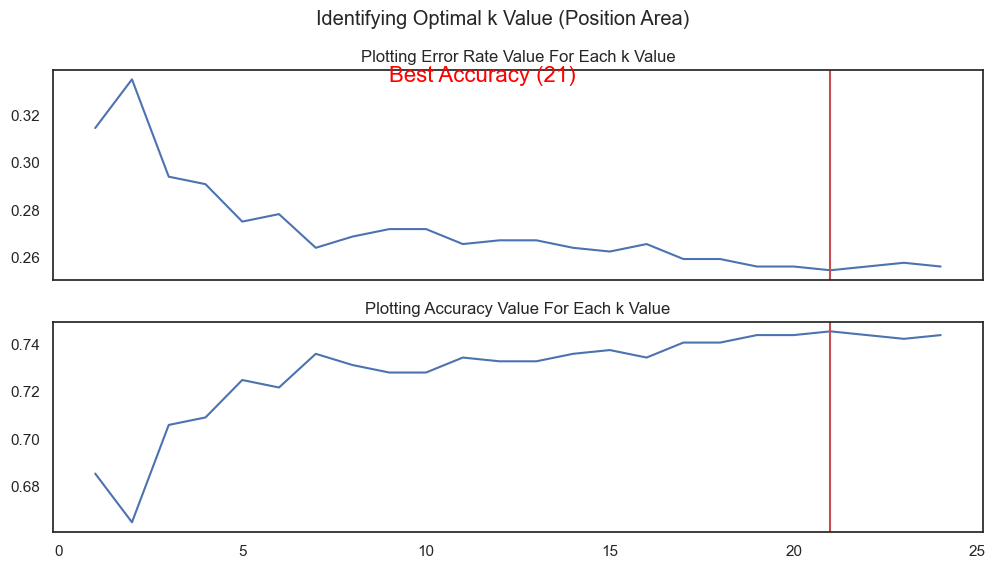

In [460]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal k Value (Position Area)')

ax1.plot(k, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(9, 0.15, f'Best Error Rate ({best_k_error_rate})', color = 'red', fontsize=16)

ax2.plot(k, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(9, 0.85, f'Best Accuracy ({best_k_accuracy})', color = 'red', fontsize=16)

In [461]:
# Define and fit KNN classifier
high_level_sub_knn=KNeighborsClassifier(n_neighbors=best_k_error_rate)
high_level_sub_knn.fit(x_train,y_train)
ypred=high_level_sub_knn.predict(x_test) #These are the predicted output values

In [462]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=sub_positions)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
                    precision    recall  f1-score   support

         Full Back       0.84      0.83      0.83       106
       Centre-Back       0.91      0.97      0.94       143
Defensive Midfield       0.52      0.57      0.55        58
  Central Midfield       0.64      0.54      0.59       105
Attacking Midfield       0.45      0.34      0.39        41
     Wide Midfield       0.00      0.00      0.00         8
            Winger       0.60      0.80      0.68        80
           Striker       0.91      0.84      0.87        95

          accuracy                           0.75       636
         macro avg       0.61      0.61      0.61       636
      weighted avg       0.74      0.75      0.74       636

Accuracy: 0.7452830188679245


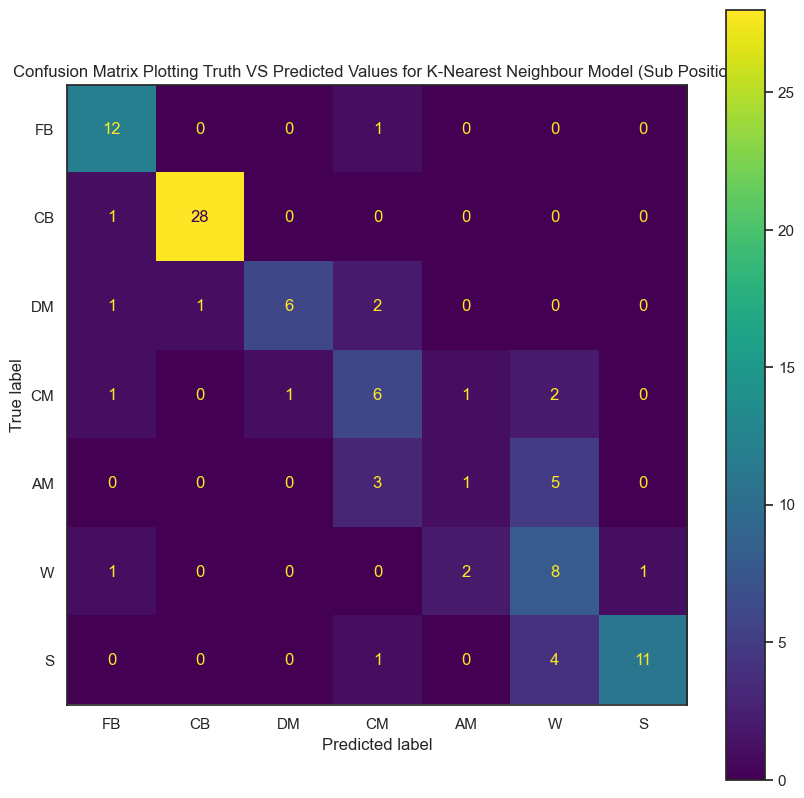

In [495]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=list(abreviated)
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Sub Position)')
cm_display.plot(ax=ax)

In [464]:
scatter = test_df.copy()
scatter['cluster'] = y_pred
scatter = scatter.drop(['player', 'position_category', 'sub_position'], axis=1)
cluster_means = scatter.groupby('cluster').mean()
scatter['ssd'] = scatter.apply(lambda row: ((row.iloc[:-2] - cluster_means.loc[row['cluster']]) ** 2).sum(), axis=1)
ssd_by_cluster = scatter.groupby('cluster')['ssd'].sum()
overall_ssd = ssd_by_cluster.sum()
overall_ssd

25.073964569492674

In [465]:
split = int(len(player_components) * 0.8)
train_df = high_level[:split]
test_df = high_level[split:]

# define x data as features and y data as labels
x_train = train_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_train = train_df['sub_position']

x_test = test_df.drop(['player', 'position_category', 'sub_position'],axis=1)
y_test = test_df['sub_position']

In [466]:
C = []
error_rate = []
accuracies = []
for val in range(1,100):
    # Define and fit KNN classifier
    knn_clf=SVC(C=val, random_state=1, kernel='rbf')
    knn_clf.fit(x_train, y_train)
    y_pred= knn_clf.predict(x_test)
    error_rate.append(np.mean(y_pred!=y_test))
    
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    C.append(val)
    
best_accuracy = accuracies.index(max(accuracies))
best_k_accuracy = C[best_accuracy] 

best_error_rate = error_rate.index(min(error_rate))
best_k_error_rate = C[best_error_rate] 

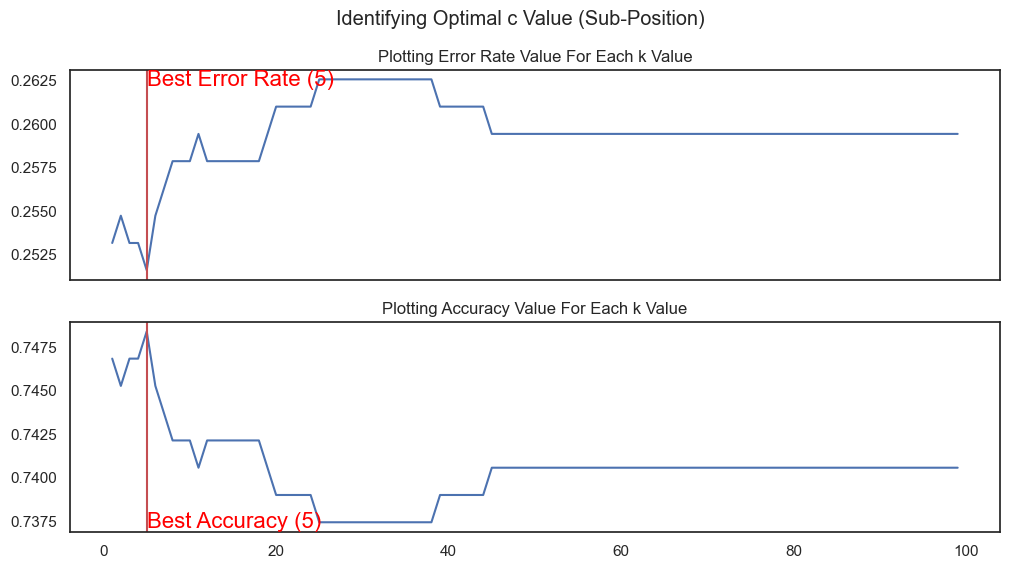

In [467]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Identifying Optimal c Value (Sub-Position)')

ax1.plot(C, error_rate)
ax1.set_title('Plotting Error Rate Value For Each k Value')
ax1.axvline(x=best_k_error_rate, color='r', linestyle='-')
ax1.set_xticklabels([])
ax1.text(best_k_error_rate, ax1.get_ylim()[1], f'Best Error Rate ({best_k_error_rate})', color='red', fontsize=16,
         verticalalignment='top')

ax2.plot(C, accuracies)
ax2.set_title('Plotting Accuracy Value For Each k Value')
ax2.axvline(x=best_k_accuracy, color='r', linestyle='-')
ax2.text(best_k_accuracy, ax2.get_ylim()[0], f'Best Accuracy ({best_k_accuracy})', color='red', fontsize=16,
         verticalalignment='bottom')

plt.show()

In [468]:
# Instantiate the Support Vector Classifier (SVC)
high_level_sub_svc = SVC(C=5, random_state=1, kernel='rbf')
# Fit the model
high_level_sub_svc.fit(x_train, y_train)

ypred = high_level_sub_svc.predict(x_test)

In [469]:
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       106
           1       0.91      0.97      0.94       143
           2       0.54      0.57      0.55        58
           3       0.63      0.54      0.58       105
           4       0.46      0.29      0.36        41
           5       0.00      0.00      0.00         8
           6       0.62      0.82      0.71        80
           9       0.91      0.85      0.88        95

    accuracy                           0.75       636
   macro avg       0.61      0.61      0.61       636
weighted avg       0.74      0.75      0.74       636

Accuracy: 0.7484276729559748


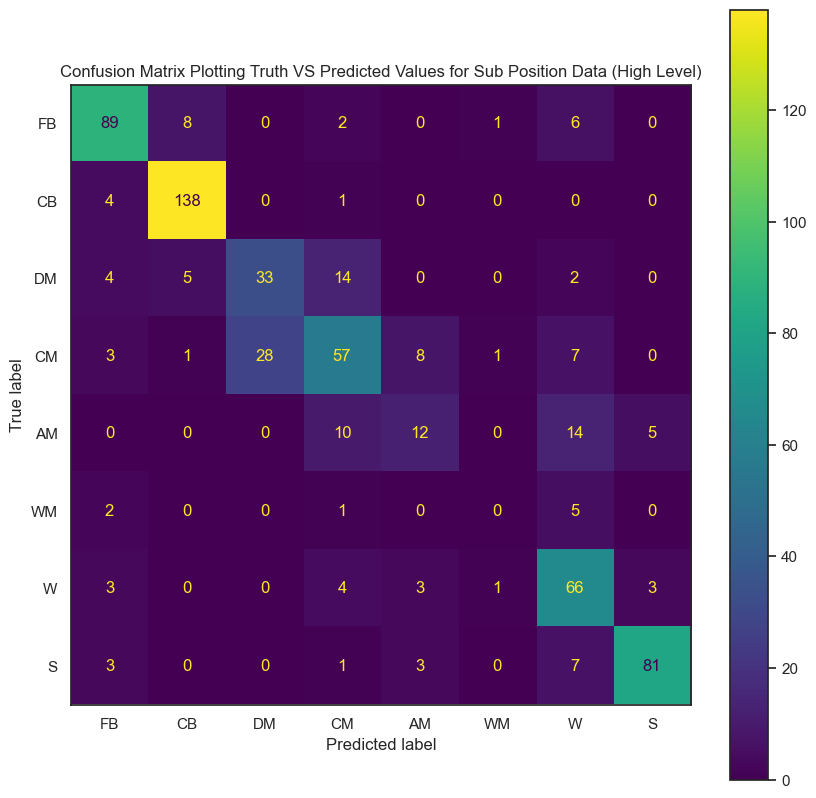

In [470]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=abreviated
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for Sub Position Data (High Level)')
cm_display.plot(ax=ax)

In [471]:
scatter = test_df.copy()
scatter['cluster'] = y_pred
scatter = scatter.drop(['player', 'position_category', 'sub_position'], axis=1)
cluster_means = scatter.groupby('cluster').mean()
scatter['ssd'] = scatter.apply(lambda row: ((row.iloc[:-2] - cluster_means.loc[row['cluster']]) ** 2).sum(), axis=1)
ssd_by_cluster = scatter.groupby('cluster')['ssd'].sum()
overall_ssd = ssd_by_cluster.sum()
overall_ssd

27.29217039249947

## Test Data

In [472]:
test_data = pd.read_csv('maual_test.csv').drop(['Unnamed: 0'], axis=1)
test_data

,Player,Nationality,Team,Position,Age,Comp Level,Games,Games Starts,Minutes,Minutes 90S,...,Touches Live Ball_Per90,Dribbles Completed_Per90,Dribbles_Per90,Dribbles Completed Pct_Per90,Miscontrols_Per90,Dispossessed_Per90,Passes Received_Per90,Progressive Passes Received_Per90,sub_position,position_category
0,Oliver McBurnie,SCO,Sheffield Utd,"FW,MF",25.0,Championship,28.0,9.0,1026.0,11.4,...,41.93,0.35,1.32,2.34,3.07,1.40,31.67,5.44,Striker,Attack
1,Joško Gvardiol,CRO,RB Leipzig,DF,19.0,Bundesliga,29.0,28.0,2409.0,26.8,...,90.07,1.38,1.83,2.82,1.04,0.75,63.10,0.52,Centre-Back,Defender
2,Armel Bella Kotchap,GER,Bochum,DF,19.0,Bundesliga,22.0,20.0,1768.0,19.6,...,51.22,0.10,0.15,3.40,0.41,0.26,27.09,0.05,Centre-Back,Defender
3,Eduard Löwen,GER,Bochum,MF,24.0,Bundesliga,26.0,15.0,1416.0,15.7,...,55.29,1.08,2.29,3.01,2.42,1.34,30.89,3.44,Central Midfield,Midfield
4,Malo Gusto,FRA,Lyon,DF,18.0,Ligue 1,30.0,21.0,1884.0,20.9,...,83.40,0.91,1.63,2.67,1.87,0.77,55.60,2.97,Full Back,Defender
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wout Faes,BEL,Reims,DF,23.0,Ligue 1,37.0,37.0,3330.0,37.0,...,49.89,0.19,0.24,2.10,0.57,0.11,30.24,0.24,Centre-Back,Defender
96,Javier Manquillo,ESP,Newcastle Utd,DF,27.0,Premier League,19.0,15.0,1257.0,14.0,...,39.86,0.71,1.29,3.97,1.00,0.21,16.36,1.00,Full Back,Defender
97,George Evans,ENG,Millwall,MF,26.0,Championship,23.0,12.0,1154.0,12.8,...,51.95,0.31,0.55,4.46,0.86,0.39,27.11,1.17,Defensive Midfield,Midfield
98,Kyle Bartley,ENG,West Brom,DF,30.0,Championship,39.0,38.0,3439.0,38.2,...,48.93,0.08,0.13,1.57,0.55,0.13,19.61,0.10,Centre-Back,Defender


In [473]:
high_level_features = test_data[features]

test_data_x = high_level_features.values
x_scaled = scaler.transform(test_data_x)
X_norm = pd.DataFrame(x_scaled)

test_components = pd.DataFrame(pca.transform(X_norm))

In [474]:
test_components['position_category'] = test_data['position_category']
test_components['sub_position'] = test_data['sub_position']

test_components['position_category'] = [position_category_encoding[position] for position in test_components['position_category']]
test_components['sub_position'] = [sub_position_encoding[position] for position in test_components['sub_position']]

# Test KNN

### Category

In [475]:
x_test = test_components.drop(['position_category', 'sub_position'],axis=1)
y_test = test_components['position_category']

In [476]:
ypred=original_category_knn.predict(x_test)

In [477]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=position_categories)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

    Defender       0.91      0.93      0.92        42
    Midfield       0.83      0.67      0.74        30
      Attack       0.82      0.96      0.89        28

    accuracy                           0.86       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.86      0.86      0.86       100

Accuracy: 0.86


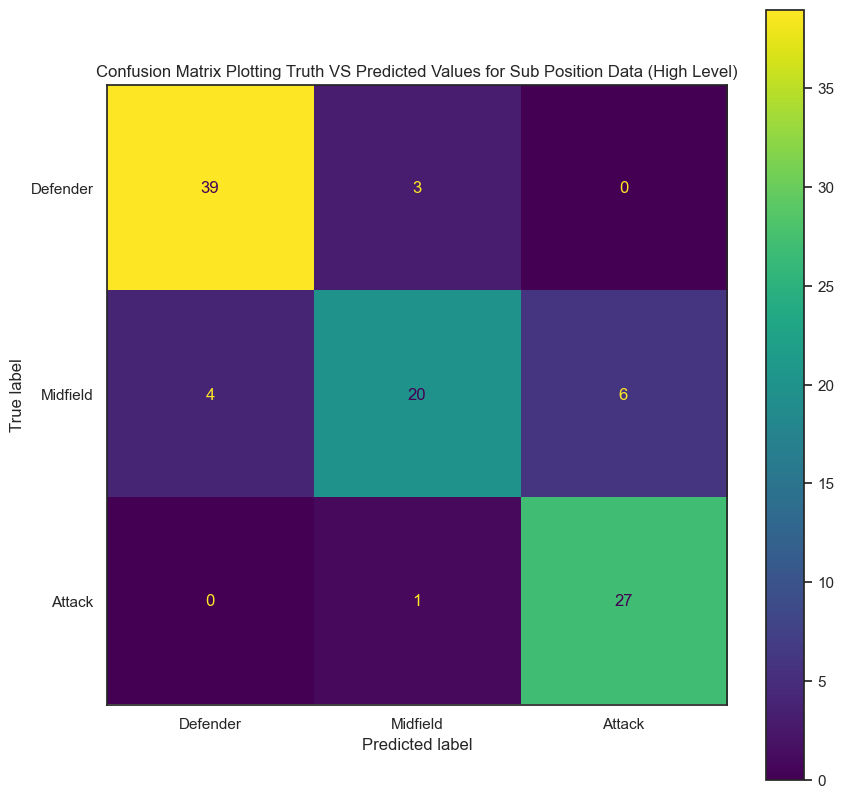

In [478]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=position_categories
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Position Area)(High Level)')
cm_display.plot(ax=ax)

## Sub Position

In [479]:
x_test = test_components.drop(['sub_position', 'position_category'],axis=1)
y_test = test_components['sub_position']

In [480]:
ypred=original_sub_knn.predict(x_test)

In [481]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
labels = list(sub_positions)
labels.remove('Wide Midfield')
report = classification_report(y_test, ypred, target_names=list(sub_positions).remove('Wide Midfield'))
print('Classification Report:',)
print (report)
accuracy = accuracy_score(y_test,ypred)
print('Accuracy:',accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.96      0.93      0.95        29
           2       0.75      0.60      0.67        10
           3       0.45      0.45      0.45        11
           4       0.50      0.11      0.18         9
           6       0.52      0.92      0.67        12
           9       0.79      0.69      0.73        16

    accuracy                           0.72       100
   macro avg       0.67      0.65      0.63       100
weighted avg       0.73      0.72      0.70       100

Accuracy: 0.72


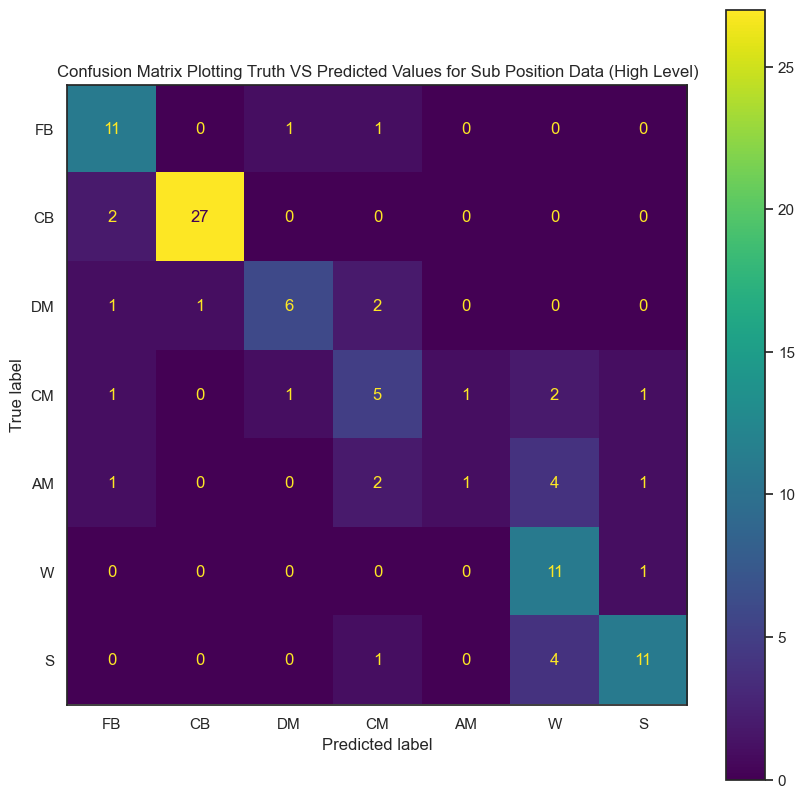

In [482]:
# Plot confusion matrix
labels = abreviated
labels.remove('WM')
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=abreviated
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Sub Position) (High Level)')
cm_display.plot(ax=ax)

In [483]:
test_vector_space = test_components.drop(['position_category', 'sub_position'], axis=1)

In [484]:
prob = high_level_svc.predict_proba(test_vector_space)
test_data_high_level = pd.DataFrame(prob)

In [485]:
test_data_high_level['position_category'] = test_components['position_category']
test_data_high_level['sub_position'] = test_components['sub_position']

In [486]:
test_data_high_level

,0,1,2,3,4,5,6,7,position_category,sub_position
0,0.006714,0.005172,0.002033,0.004996,0.030935,0.007520,0.082272,0.860357,2,9
1,0.117435,0.765806,0.064171,0.025453,0.004838,0.002785,0.011970,0.007541,0,1
2,0.021006,0.962134,0.010077,0.001349,0.000383,0.000627,0.000826,0.003598,0,1
3,0.025780,0.021927,0.037984,0.205766,0.265264,0.078928,0.349211,0.015140,1,3
4,0.980108,0.002485,0.003107,0.002580,0.001481,0.004177,0.005759,0.000302,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0.022337,0.943480,0.025017,0.002485,0.000535,0.000673,0.000935,0.004538,0,1
96,0.475250,0.104144,0.225171,0.072212,0.011834,0.013696,0.090688,0.007005,0,0
97,0.010369,0.010988,0.323854,0.630602,0.012016,0.005348,0.006144,0.000678,1,2
98,0.025212,0.950410,0.016012,0.001960,0.000409,0.000331,0.000775,0.004892,0,1


In [487]:
x_test = test_data_high_level.drop(['sub_position', 'position_category'],axis=1)
y_test = test_data_high_level['position_category']

In [488]:
ypred=high_level_category_knn.predict(x_test)

In [489]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
report = classification_report(y_test, ypred, target_names=position_categories)
print('Classification Report:')
print(report)
accuracy = accuracy_score(y_test, ypred)
print('Accuracy:', accuracy)

Classification Report:
              precision    recall  f1-score   support

    Defender       0.93      0.98      0.95        42
    Midfield       0.78      0.70      0.74        30
      Attack       0.79      0.82      0.81        28

    accuracy                           0.85       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.85      0.85      0.85       100

Accuracy: 0.85


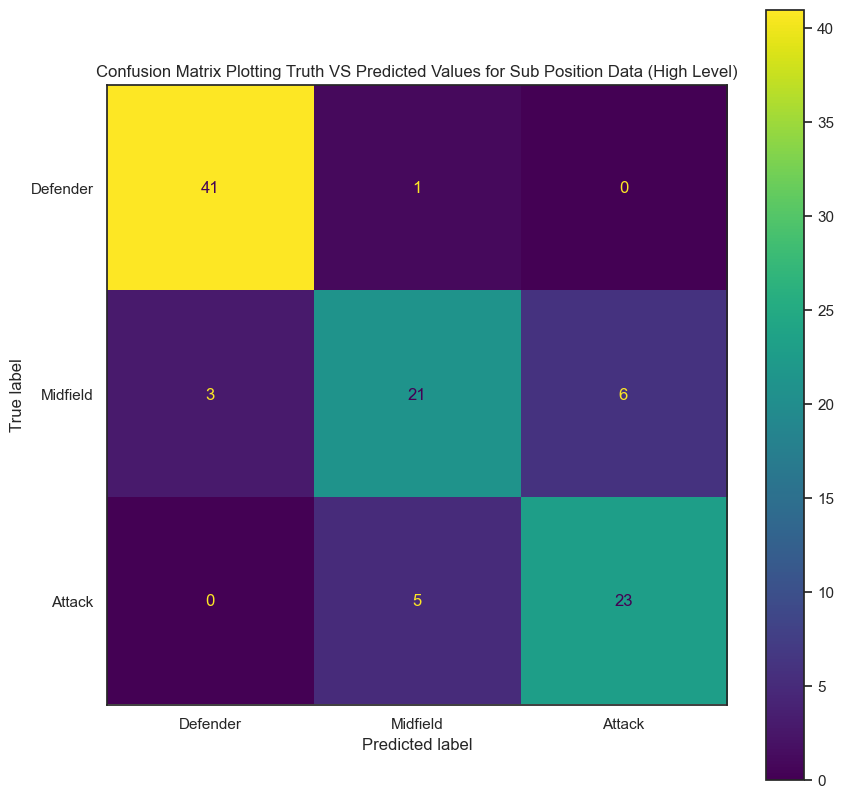

In [490]:
# Plot confusion matrix
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=position_categories
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('CConfusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Position Area) (High Level)')
cm_display.plot(ax=ax)

In [491]:
x_test = test_data_high_level.drop(['sub_position', 'position_category'],axis=1)
y_test = test_data_high_level['sub_position']

In [492]:
ypred=high_level_sub_knn.predict(x_test)

In [493]:
# Create Confusion Matrix, Classifictaion Report and Accuracy for model
cf = confusion_matrix(y_test, ypred)
labels = list(sub_positions)
labels.remove('Wide Midfield')
report = classification_report(y_test, ypred, target_names=list(sub_positions).remove('Wide Midfield'))
print('Classification Report:',)
print (report)
accuracy = accuracy_score(y_test,ypred)
print('Accuracy:',accuracy)

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.92      0.83        13
           1       0.97      0.97      0.97        29
           2       0.86      0.60      0.71        10
           3       0.46      0.55      0.50        11
           4       0.25      0.11      0.15         9
           6       0.42      0.67      0.52        12
           9       0.92      0.69      0.79        16

    accuracy                           0.72       100
   macro avg       0.66      0.64      0.64       100
weighted avg       0.73      0.72      0.71       100

Accuracy: 0.72


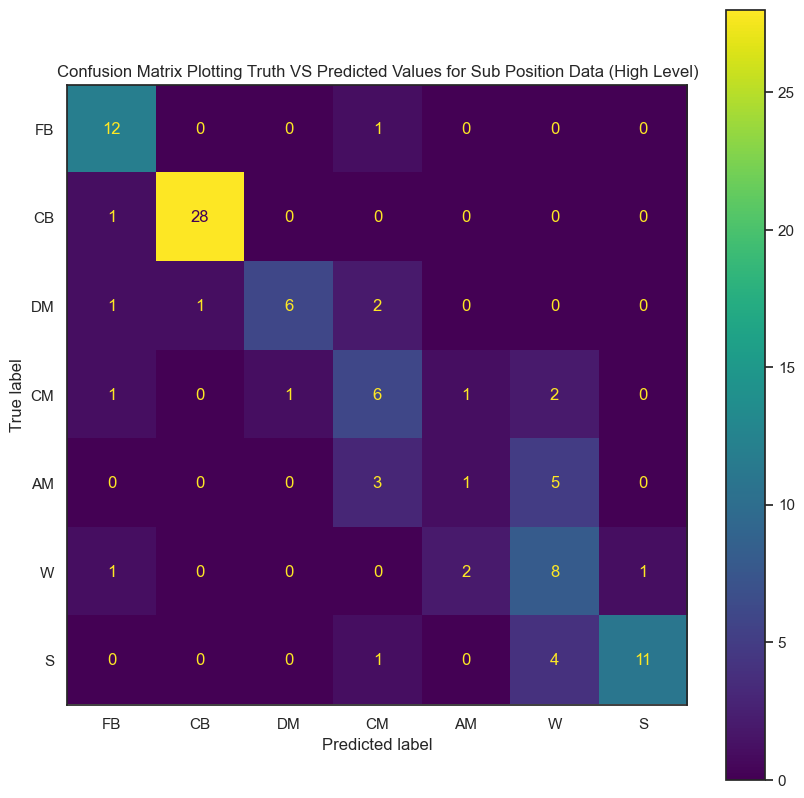

In [494]:
# Plot confusion matrix
labels = abreviated
# labels.remove('WM')
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cf, 
    display_labels=abreviated
    
)

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Confusion Matrix Plotting Truth VS Predicted Values for K-Nearest Neighbour Model (Sub Position) (High Level)')
cm_display.plot(ax=ax)

## Player Comparisons

In [ ]:
leagues = season_stats['Comp Level']
choices = pd.read_csv(r'participant_choices.csv', encoding='latin-1')
choices.columns = ['time', 'participant_name', 'league', 'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6', 'player_7', 'player_8', 'player_9', 'player_10']
choices = choices.drop(['time'], axis=1)

In [ ]:
particpants = choices['participant_name'].to_list()
choices_dict = {}
leagues_dict = {}
for row in range(21):
    participant = choices.loc[row, :].values.flatten().tolist()
    leagues = participant[1].split(', ')
    leagues_dict[participant[0]] = [league.split(' (')[0] for league in leagues]
    choices_dict[participant[0]] = participant[2:]
    
leagues = season_stats['Comp Level']

In [ ]:
# Create csv output for each participant with each players output on separate sheet
for name in particpants[0:]:
    print(name)
    with pd.ExcelWriter(f'Output Files/{name}_output.xlsx') as writer:
        print('-------------------------------------------')
        filter_leagues = leagues_dict[name]

    #     df_list = []
        count = 0
        for player in choices_dict[name]:
            count += 1
            player = player.strip()
            original = original_vector_space.copy()
            original['league'] = leagues
            original_filtered = original[original['league'].isin(filter_leagues)]

            improved = high_level_vector_space.copy()
            improved['league'] = leagues
            improved_filtered = improved[improved['league'].isin(filter_leagues)]
            if player not in original_filtered['player'].to_list():           
                chosen = original[original['player'] == player]
                original_filtered = original_filtered.append(chosen)

            original_filtered = original_filtered.drop('league', axis=1)

            original_player_list = euclidean_similar_players(player, original_filtered)

            # Imporved
            if player not in improved_filtered['player'].to_list():
                chosen = improved[improved['player'] == player]
                improved_filtered = improved_filtered.append(chosen)

            improved_filtered = improved_filtered.drop('league', axis=1)

            improved_player_list = euclidean_similar_players(player, improved_filtered)

            original_player_list['player2'] = improved_player_list['player']
            original_player_list['value2'] = improved_player_list['value']

            output_table = original_player_list.copy()
            output_table[' '] = [' ' for i in range(len(output_table['player']))]

            if count % 2 != 0:
                print(f'{player}: Original first')
                output_table = output_table[['player', 'value', ' ', 'player2', 'value2']]

            else:
                print(f'{player}: Improved first')
                output_table = output_table[['player2', 'value2', ' ', 'player', 'value']]

            output_table.columns = ['Table1 Player', 'Table1 Value', ' ', 'Table2 Player', 'Table2 Value']

            split = player.split(' ')
            player = split[-1]
            output_table.to_excel(writer, sheet_name=f'{player}')